In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, time
import numpy.random as rn
import torch
import matplotlib.patches as mpatches

In [2]:
# Step 1: Create multivariate gaussians and visual
#numpy.random.multivariate_normal(mean, cov[, size, check_valid, tol
dim=2 # data dimension
seed=512
nsamples=50000 # total number of samples
ntrain=4000
discriminator_offset=0.01
distribution_offset=0.01
var=0.05 #0.1
uniform_width=1.25
ntasks=4
batch_size=20
alpha=0.25 #0.25,0.5,0.75
learning_rate =0.3*1e-5
hidden_units = 10
gradient_steps = 1
dev = 'cpu' #'cuda'
icon=['bx','ro','g*','c<']
use_hard_buffer=True
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5
loss_window_length=10


tasks={}
inputs={}
labels={}
test_inputs={}
test_labels={}

        

In [3]:
def sample_data():
    global tasks, inputs, labels, test_inputs, test_labels
    # seed
    rn.seed(512)
    tasks={}
    stime=time.time()
    # sample points for four tasks related to four quadrants
    for q in range(ntasks):
        #print("quadrant {0}".format(q))
        # step 1 sample points in quadrant uniformly from [0:1]
        if q == 0: # 1th quadrant
            xs=rn.uniform(distribution_offset,uniform_width,nsamples)
            ys=rn.uniform(distribution_offset,uniform_width,nsamples)
        elif q == 1: # 2nd quadrant
            xs=rn.uniform(-distribution_offset,-uniform_width,nsamples)
            ys=rn.uniform(distribution_offset,uniform_width,nsamples)
        elif q == 2: # 3th quadrant
            xs=rn.uniform(-distribution_offset,-uniform_width,nsamples)
            ys=rn.uniform(-distribution_offset,-uniform_width,nsamples)
        else: #4th quadrant
            xs=rn.uniform(distribution_offset,uniform_width,nsamples)
            ys=rn.uniform(-distribution_offset,-uniform_width,nsamples)
        samples=[]
        for i in range(len(xs)):
            sample=[xs[i],ys[i]]
            for j in range(dim-2): #add noise gausians in other dimensions
                sample.append(rn.uniform(-uniform_width,uniform_width))
            samples.append(sample)
        tasks[q]=np.asarray(samples)
        #tasks[q]=np.asarray([[xs[i],ys[i]] for i in range(len(xs))])
        if verbose: plt.plot(xs,ys,icon[q%ntasks])
    if verbose: plt.show()
    #print "step 1: ",time.time()-stime

    #stime=time.time()
    
    inputs={}
    labels={}
    # Step 3: Sample correct distribution given certain alpha
    for q in range(ntasks):
        pos_inputs=[]
        neg_inputs=[]
        other_quadrants=range(ntasks)
        del other_quadrants[q]
        while not (len(pos_inputs) == ntrain/2 and len(neg_inputs) == ntrain/2): 
            if rn.binomial(1,alpha): #1 if original task, 0 if data sampled from 1 of the others.
                q_temp=q
            else: # pick from random other quadrant
                q_temp=rn.choice(other_quadrants)
            sample=tasks[q_temp][0]
            # samples are popped from the distribution to avoid them to be reused.
            tasks[q_temp]=tasks[q_temp][1:]
            if np.sqrt(np.sum(sample**2))>1+discriminator_offset and len(neg_inputs) < ntrain/2:
                neg_inputs.append(sample) 
            #elif np.sqrt(np.sum(sample**2))<1:
            elif np.sqrt(np.sum(sample**2))<1-discriminator_offset and len(pos_inputs) < ntrain/2:
                pos_inputs.append(sample) 
            else: #discard samples on border as task becomes too hard 
                pass
        pos_inputs=pos_inputs[:ntrain/2]
        neg_inputs=neg_inputs[:ntrain/2]
        inputs[q]=pos_inputs+neg_inputs
        rn.shuffle(inputs[q])
        labels[q]=[]
        for sample in inputs[q]:
            if np.sqrt(np.sum(sample**2))>1+discriminator_offset:
                labels[q].append(0) 
            #elif np.sqrt(np.sum(sample**2))<1:
            elif np.sqrt(np.sum(sample**2))<1-discriminator_offset:
                labels[q].append(1) 
            else: #discard samples on border as task becomes too hard 
                pass
        #if verbose: plt.plot(sample[0],sample[1],icon[q])
        print('{0}:proportion positive/total={1}'.format(q,float(sum(labels[q]))/len(labels[q])))
    #if verbose: plt.show()

    #print "step 2: ",time.time()-stime
    #stime=time.time()

    # draw some extra test data to evaluate
    # label points according to distance to center
    test_inputs={}
    test_labels={}
    for q in range(ntasks):
        test_inputs_pos=[]
        test_inputs_neg=[]
        while len(test_inputs_pos)<ntest/2 or len(test_inputs_neg)<ntest/2:
            sample=tasks[q][0]
            tasks[q]=tasks[q][1:]
            # map sample to 2D plane for visualizations
            if len(sample)>2: sample[2:]=0
            if np.sqrt(np.sum(sample**2)) > 1+discriminator_offset:
                test_inputs_neg.append(sample)
                #test_inputs[q].append(sample)
                #test_labels[q].append(0)
            #elif np.sqrt(np.sum(sample**2)) < 1:
            elif np.sqrt(np.sum(sample**2)) < 1-discriminator_offset:
                test_inputs_pos.append(sample)
                #test_inputs[q].append(sample)
                #test_labels[q].append(1)
            else:
                pass
        test_inputs[q]=np.asarray(test_inputs_pos[:ntest/2]+test_inputs_neg[:ntest/2])
        test_labels[q]=[1]*(ntest/2)+[0]*(ntest/2)
        #print test_inputs[q].shape
    # Check distribution
    for q in range(ntasks):
        positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==1]
        negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==0]
    
        if verbose: plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
        if verbose: plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
    if verbose: plt.show()
    print "sampling data duration: ",time.time()-stime

In [4]:
# Step 4: Define network
def experiment(use_hard_buffer=False,continual_learning=False,recent_buffer_size=30,hard_buffer_size=30):
    count_updates=0
    torch.manual_seed(seed)
    device = torch.device(dev)
    model = torch.nn.Sequential(
              torch.nn.Linear(dim, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, 2, bias=False),
    ).to(device)

    loss_fn = torch.nn.MSELoss(reduction='none')
    #loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
    # Reinitialize model
    for p in model.parameters():
        torch.nn.init.normal_(p, 0, 0.1)
    # Step 5: Define online loop through data + evaluation + visualization
    # Step 6: Define hard buffer
    # Step 7: Detect loss saturation
    # Step 8: >>Calculate importance weights<<
    # Step 9: Add regularizer
    stime=time.time()
    verbose=False
    losses=[]
    test_loss={i:[] for i in range(ntasks)}
    recent_buffer=[]
    hard_buffer=[]
    # loss dectection
    loss_window=[]
    loss_window_means=[]
    loss_window_variances=[]
    update_tags=[]
    new_peak_detected=True
    # MAS regularization: list of 3 weights vectors as there are 3 layers.
    star_variables=[]
    omegas=[] #initialize with 0 importance weights
    for t in range(ntasks):
        for s in range(len(inputs[t])):
            # plt.scatter(inputs[t][s][0],inputs[t][s][1],color='red' if labels[t][s]==0 else 'blue')
            # save experience in replaybuffer
            recent_buffer.append({'state':inputs[t][s],
                                 'trgt':labels[t][s]})
            if len(recent_buffer) > recent_buffer_size:
                del recent_buffer[0]
            
            # Train model on replaybuffer when it is full:
            if len(recent_buffer) == recent_buffer_size:
                msg='task: {0} step: {1}'.format(t,s)
                x=[_['state'] for _ in recent_buffer]
                y=[_['trgt'] for _ in recent_buffer]
                if use_hard_buffer:
                    x.extend([_['state'] for _ in hard_buffer])
                    y.extend([_['trgt'] for _ in hard_buffer])

                #for gs in range(2*gradient_steps if not use_hard_buffer else gradient_steps):
                for gs in range(gradient_steps):
                    y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(y),2).scatter_(1,torch.from_numpy(np.asarray(y).reshape(-1,1)).type(torch.LongTensor),1.).type(torch.FloatTensor)
                    #y_sup=torch.from_numpy(np.asarray(y)).type(torch.LongTensor)
                    train_loss = loss_fn(y_pred,y_sup)
                    total_loss = loss_fn(y_pred,y_sup)
                    if gs==0:
                        first_train_loss=train_loss.detach().numpy()
                    # add MAS regularization to train loss...
                    if continual_learning and len(star_variables)!=0 and len(omegas)!=0:
                        for pindex, p in enumerate(model.parameters()):
                            total_loss+=MAS_weight/2.*torch.sum(torch.from_numpy(omegas[pindex]).type(torch.float32)*(p-star_variables[pindex])**2)
                            
                    # print different losses to adjust MAS weight
                    # train
                    optimizer.zero_grad()
                    #model.zero_grad()
#                    train_loss.backward()
                    torch.sum(total_loss).backward()
                    #with torch.no_grad():
                    #    for param in model.parameters(): param.data -= learning_rate * param.grad
                    optimizer.step()
                
                # save training accuracy
                y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                accuracy = np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==y)
                loss=train_loss.detach().numpy()
                msg+=' train: {0:0.3f}'.format(np.mean(loss))
                losses.append(np.mean(accuracy))
                
                
                # add loss to loss_window and detect importance weight update
                loss_window.append(np.mean(first_train_loss))
                if len(loss_window)>loss_window_length: del loss_window[0]
                loss_window_mean=np.mean(loss_window)
                loss_window_variance=np.var(loss_window)
                if not new_peak_detected and loss_window_mean > last_loss_window_mean+np.sqrt(last_loss_window_variance):
                    new_peak_detected=True
                    print("train {0} vs total {1}".format(torch.sum(train_loss),torch.sum(total_loss)))
                    
                if continual_learning and loss_window_mean < loss_window_mean_threshold and loss_window_variance < loss_window_variance_threshold and new_peak_detected:
                    #print("Update importance weights")
                    print("train {0} vs total {1}".format(torch.sum(train_loss),torch.sum(total_loss)))
                    count_updates+=1
                    update_tags.append(0.01)
                    last_loss_window_mean=loss_window_mean
                    last_loss_window_variance=loss_window_variance
                    new_peak_detected=False
                    
                    # calculate importance weights and update star_variables
                    gradients=[0 for p in model.parameters()]
                    # calculate imporatance based on each sample in recent + hardbuffer
                    # todo: add only hard buffer option
                    #if use_hard_buffer: # use solely hard buffer data if there is a hard buffer
                    #    x=[_['state'] for _ in hard_buffer]
                    
                    #for sx in [_['state'] for _ in recent_buffer]:
                    for sx in x:
                        model.zero_grad()
                        y_pred=model(torch.from_numpy(np.asarray(sx).reshape(-1,dim)).type(torch.float32))
                        torch.norm(y_pred, 2, dim=1).backward()
                        #torch.sum(torch.norm(y_pred, 2, dim=1)).backward()
                        for pindex, p in enumerate(model.parameters()):
                            g=p.grad.data.clone().detach().numpy()
                            gradients[pindex]+=np.abs(g)
                            
                    omegas_old = omegas[:]
                    omegas=[]
                    star_variables=[]
                    for pindex, p in enumerate(model.parameters()):
                        if len(omegas_old) != 0:
                            omegas.append(1/count_updates*gradients[pindex]+(1-1/count_updates)*omegas_old[pindex])
                        else:
                            omegas.append(gradients[pindex])
                        star_variables.append(p.data.clone().detach())
                    
                else:
                    update_tags.append(0)
                loss_window_means.append(loss_window_mean)
                loss_window_variances.append(loss_window_variance)

                #update hard_buffer
                if use_hard_buffer:
                    hard_buffer=[]
                    #hard_loss=train_loss.detach().numpy()
                    hard_loss=total_loss.detach().numpy()
                    loss=np.mean(hard_loss,axis=1)
                    try:
                        sorted_inputs=[np.asarray(lx) for _,lx in reversed(sorted(zip(loss.tolist(),x),key= lambda f:f[0]))]
                        sorted_targets=[ly for _,ly in reversed(sorted(zip(loss.tolist(),y),key= lambda f:f[0]))]
                    except:
                        import pdb; pdb.set_trace()
                    for i in range(min(hard_buffer_size,len(sorted_inputs))):
                        hard_buffer.append({'state':sorted_inputs[i],
                                           'trgt':sorted_targets[i]})
                #evaluate on test set
                for i in range(ntasks):
                    y_pred=model(torch.from_numpy(test_inputs[i].reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(test_inputs[i]),2).scatter_(1,torch.from_numpy(np.asarray(test_labels[i]).reshape(-1,1)),1.).type(torch.FloatTensor)
                    #loss=loss_fn(y_pred,y_sup).detach().numpy()
                    test_loss[i].append(np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==test_labels[i]))
                    msg+=' test[{0}]: {1:0.3f}'.format(i,np.mean(loss))
                if verbose:
                    print(msg)
                # empty recent buffer after training couple of times
                recent_buffer = []
            
            
    if False and use_hard_buffer:
        xs_pos=[_['state'][0] for _ in hard_buffer if _['trgt']==1]
        ys_pos=[_['state'][1] for _ in hard_buffer if _['trgt']==1]
        xs_neg=[_['state'][0] for _ in hard_buffer if _['trgt']==0]
        ys_neg=[_['state'][1] for _ in hard_buffer if _['trgt']==0]
        plt.scatter(xs_pos,ys_pos,color='blue')
        plt.scatter(xs_neg,ys_neg,color='red')
        plt.title('replay buffer')
        plt.show()
        
    if True:
        for q in range(ntasks):
            y_pred=model(torch.from_numpy(test_inputs[q].reshape(-1,dim)).type(torch.float32)).detach().numpy()
            positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==1]
            negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==0]
            plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
            plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
        plt.ylim((0.5,1.0))
        plt.xlim((0.5,1.0))
        plt.show()
    
    print("duration: {0}minutes, count updates: {1}".format((time.time()-stime)/60., count_updates))
    return losses, loss_window_means, update_tags, loss_window_variances, test_loss
#     return losses, test_loss



In [6]:
def meta_experiment(tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']):
    print("\n\n\n\nStart experiment with alpha: {0}".format(alpha))
    training_losses={}
    test_losses={}
    loss_window_means={}
    update_tags={}
    loss_window_variances={}
    #tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
    settings={'Online Continual':(True, True,batch_size,hard_batch_size),
             'Online Continual No Hardbuffer':(False, True,batch_size,hard_batch_size),
             'Online':(True, False,batch_size,hard_batch_size),
             'Online No Hardbuffer':(False, False,batch_size,hard_batch_size)}
    colors={'Online Continual':'C2',
             'Online Continual No Hardbuffer':'C3',
             'Online':'C4',
             'Online No Hardbuffer':'C5'}



    for tag in tags:
        print("\n{0}".format(tag))
        # losses, loss_window_means, update_tags, loss_window_variances, test_loss=experiment(use_hard_buffer,continual_learning)
        training_losses[tag], loss_window_means[tag], update_tags[tag], loss_window_variances[tag], test_losses[tag]=experiment(settings[tag][0],settings[tag][1],settings[tag][2],settings[tag][3])

    # Plot loss window mean, variance and update for each tag
    if True and 'Online Continual' in tags or 'Online Continual No Hardbuffer' in tags:
        for dataname in ['loss_window_means','update_tags','loss_window_variances']:
            legend=[]
            plt.title(dataname)
            #for i in range(ntasks): plt.axvline(x=(i+1)*ntrain,color='gray')
            for tag in tags:    
                plt.plot(eval(dataname)[tag],color=colors[tag])
                legend.append(mpatches.Patch(color=colors[tag], label=tag))
            plt.legend(handles=legend)
            plt.show()
    #print loss_window_means
    
    # Plot training loss
    if True:
        legend=[]
        plt.title('training accuracy')
        #for i in range(ntasks): plt.axvline(x=(i+1)*ntrain,color='gray')
        for tag in tags:    
            plt.plot(training_losses[tag][::10],color=colors[tag])
            legend.append(mpatches.Patch(color=colors[tag], label=tag))
        plt.legend(handles=legend)
        plt.show()
        
    # Plot test loss
    if True:
        subsample=1
#        for task in range(ntasks):
        for task in range(2):
            legend=[]
            plt.title('test loss task {0}'.format(task))
            plt.ylim((0,1))
            #for i in range(ntasks): plt.axvline(x=(i+1)*ntrain,color='gray')
            for tag in tags:  
                plt.plot(np.arange(0,len(test_losses[tag][task]),subsample),test_losses[tag][task][::subsample],color=colors[tag])
                legend.append(mpatches.Patch(color=colors[tag], label=tag))
            plt.legend(handles=legend)
            plt.show()
            print(tag,task,test_losses[tag][task][-1]*100)

    # Get final average accuracy for each tag:
    for tag in tags:
        print "{0}: {1}".format(tag,np.mean([test_losses[tag][task][-1]*100 for task in range(ntasks)]))
        for task in range(ntasks): print("{0}: task {1}: {2}".format(tag,task,test_losses[tag][task][-1]*100))
    return [np.mean([test_losses[tag][task][-1]*100 for task in range(ntasks)]) for tag in sorted(tags)]


0:proportion positive/total=0.5
1:proportion positive/total=0.5
sampling data duration:  56.8487610817




Start experiment with alpha: 0.25

Online No Hardbuffer


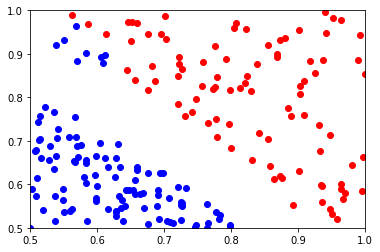

duration: 0.186174984773minutes, count updates: 0

Online


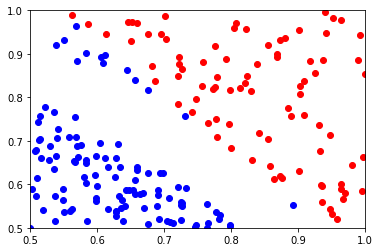

duration: 0.165222215652minutes, count updates: 0

Online Continual
train 0.315619587898 vs total 0.315619587898
train 1.55810368061 vs total 1.65719592571
train 0.39705568552 vs total 0.510918617249
train 0.614611208439 vs total 0.706709086895
train 0.431120663881 vs total 0.50095897913
train 3.62664079666 vs total 3.92615270615
train 0.20293776691 vs total 0.395174980164
train 1.62537026405 vs total 1.77693247795
train 0.719013512135 vs total 0.902156293392
train 0.362529218197 vs total 0.478670835495
train 0.542963087559 vs total 0.704710364342
train 2.99083590508 vs total 3.21411395073
train 0.940745413303 vs total 1.10420382023
train 0.149713769555 vs total 0.292290210724
train 0.647721886635 vs total 0.705293715
train 0.384779632092 vs total 0.495218783617
train 0.384779632092 vs total 0.495218783617
train 0.225537523627 vs total 0.274143636227
train 0.129494875669 vs total 0.165728121996
train 0.192672148347 vs total 0.399241060019
train 1.70619750023 vs total 1.87691807747
trai

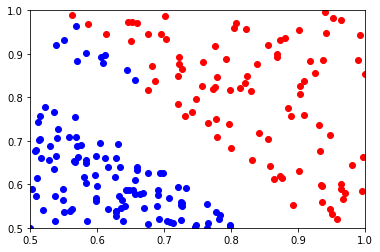

duration: 0.341443316142minutes, count updates: 13


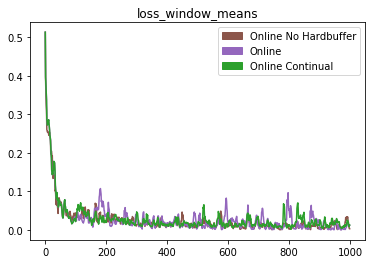

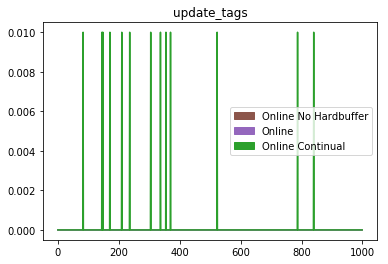

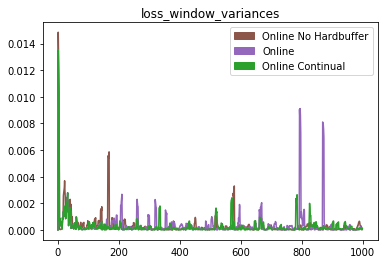

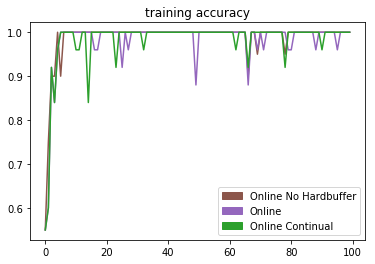

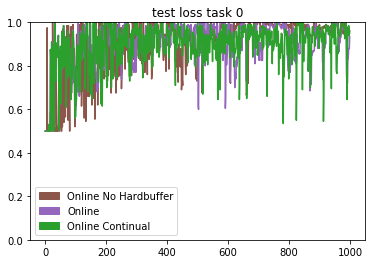

('Online Continual', 0, 95.0)


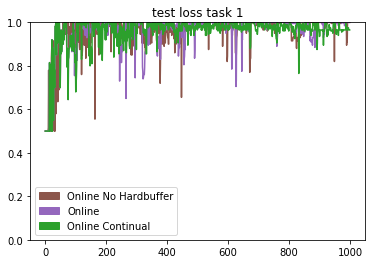

('Online Continual', 1, 96.5)
Online No Hardbuffer: 98.0
Online No Hardbuffer: task 0: 96.0
Online No Hardbuffer: task 1: 100.0
Online: 96.75
Online: task 0: 93.5
Online: task 1: 100.0
Online Continual: 95.75
Online Continual: task 0: 95.0
Online Continual: task 1: 96.5
0:proportion positive/total=0.5
1:proportion positive/total=0.5
sampling data duration:  50.3755540848




Start experiment with alpha: 0.9

Online No Hardbuffer


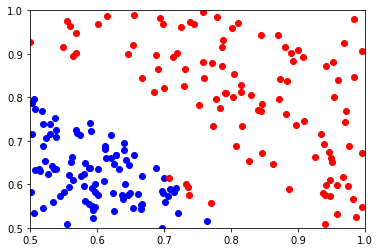

duration: 0.17186811765minutes, count updates: 0

Online


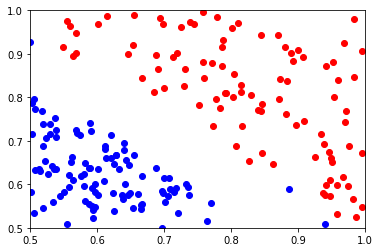

duration: 0.171649535497minutes, count updates: 0

Online Continual
train 1.98761212826 vs total 1.98761212826
train 1.91095876694 vs total 2.14915037155
train 2.04824709892 vs total 2.27679419518
train 0.345946699381 vs total 0.437225848436
train 0.468058586121 vs total 0.683892846107
train 4.14860153198 vs total 4.4290137291
train 0.728115141392 vs total 0.887285470963
train 0.533645868301 vs total 0.584971964359
train 0.533645868301 vs total 0.584971964359
train 0.219899505377 vs total 0.316092431545
train 0.979785621166 vs total 1.11294710636
train 1.65977454185 vs total 1.82663583755
train 0.576403737068 vs total 0.716929316521
train 1.27333319187 vs total 1.49419093132
train 0.210686221719 vs total 0.486825525761
train 2.17773580551 vs total 2.30547642708
train 0.147090852261 vs total 0.259497195482
train 1.03606081009 vs total 1.09052324295
train 1.03606081009 vs total 1.09052324295
train 1.054246068 vs total 1.20297670364
train 0.144449368119 vs total 0.23645979166
train 2.7354

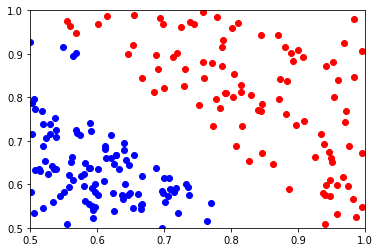

duration: 0.354197816054minutes, count updates: 22


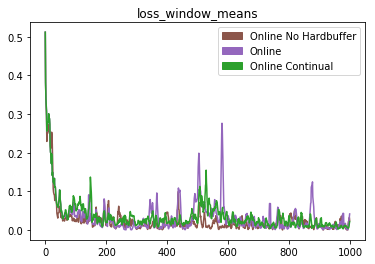

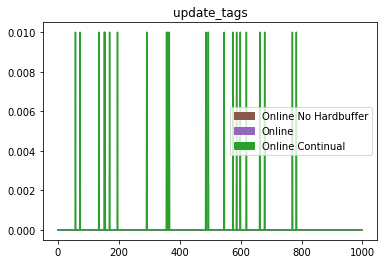

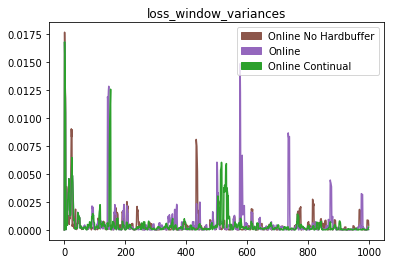

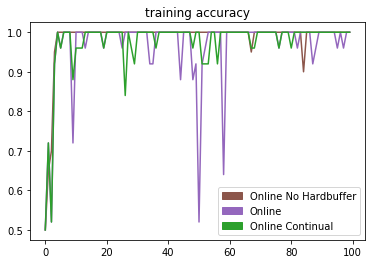

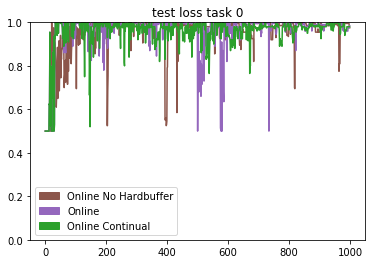

('Online Continual', 0, 98.0)


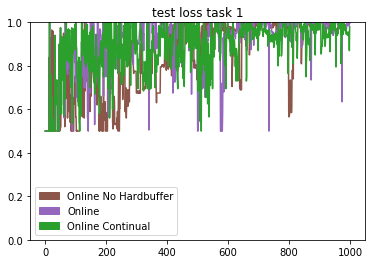

('Online Continual', 1, 98.0)
Online No Hardbuffer: 98.75
Online No Hardbuffer: task 0: 97.5
Online No Hardbuffer: task 1: 100.0
Online: 99.0
Online: task 0: 98.5
Online: task 1: 99.5
Online Continual: 98.0
Online Continual: task 0: 98.0
Online Continual: task 1: 98.0
0:proportion positive/total=0.5
1:proportion positive/total=0.5
sampling data duration:  49.4946630001




Start experiment with alpha: 1.0

Online No Hardbuffer


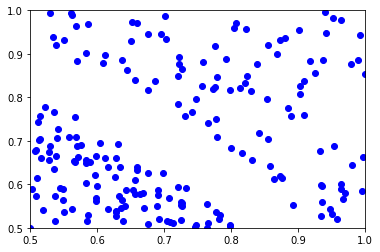

duration: 0.164375750224minutes, count updates: 0

Online


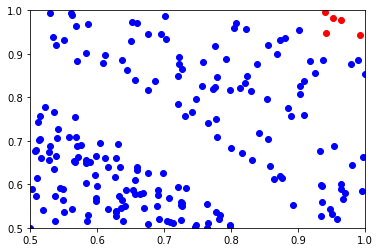

duration: 0.171972986062minutes, count updates: 0

Online Continual
train 1.1811106205 vs total 1.1811106205
train 1.45073568821 vs total 1.48213732243
train 0.414015203714 vs total 0.602604031563
train 0.407828509808 vs total 0.468100786209
train 0.325020492077 vs total 0.484762310982
train 1.22107684612 vs total 1.5601272583
train 0.240077853203 vs total 0.346523940563
train 0.583498477936 vs total 0.715194225311
train 1.0211327076 vs total 1.1850515604
train 0.777875840664 vs total 1.01151287556
train 0.46379584074 vs total 0.610495984554
train 4.98159265518 vs total 5.3430519104
train 0.733306527138 vs total 0.817030191422
train 1.04371190071 vs total 1.30622732639
train 0.342034071684 vs total 0.477117359638
train 9.24216079712 vs total 9.66643714905
train 0.089525513351 vs total 0.729196369648
train 0.901612460613 vs total 0.996410787106
train 0.201104834676 vs total 0.300390571356
train 3.27197241783 vs total 3.28843927383
train 0.292076170444 vs total 0.316281378269
train 0.157

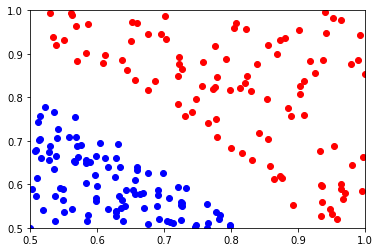

duration: 0.36667141517minutes, count updates: 27


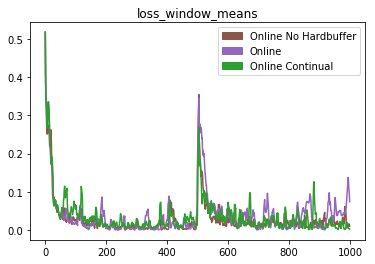

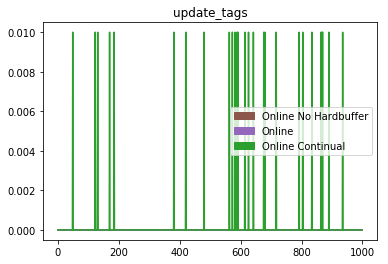

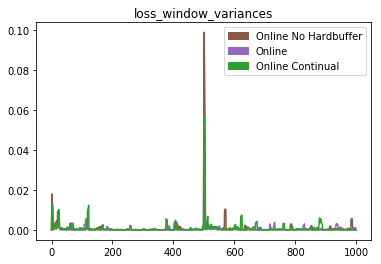

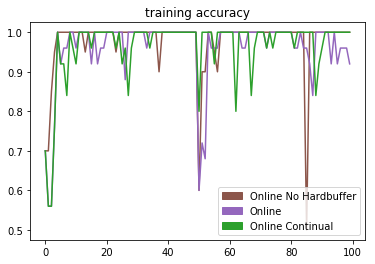

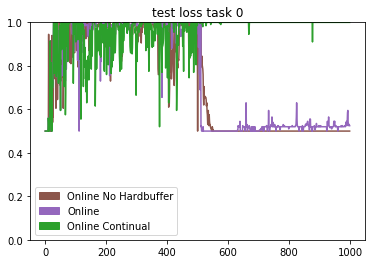

('Online Continual', 0, 100.0)


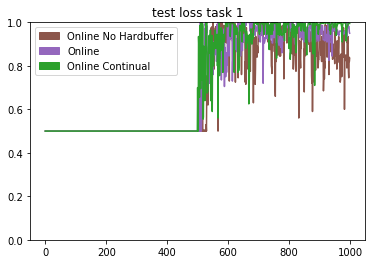

('Online Continual', 1, 99.5)
Online No Hardbuffer: 66.75
Online No Hardbuffer: task 0: 50.0
Online No Hardbuffer: task 1: 83.5
Online: 73.75
Online: task 0: 52.5
Online: task 1: 95.0
Online Continual: 99.75
Online Continual: task 0: 100.0
Online Continual: task 1: 99.5
duration: 290.525724173


In [7]:
###############################
# CHANGE:  increase batchsize #
###############################
dim=4 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.
nsamples=1000000
discriminator_offset=0.05 #0.1
distribution_offset=0.5 #0.4
ntest=200
############
# TRAINING #
############
learning_rate=0.01
ntrain=10000
batch_size=20
hidden_units=10
gradient_steps=10
seed=512
ntasks=2
##############
# OUR METHOD #
##############
hard_batch_size=5
loss_window_length=5
loss_window_mean_threshold=0.03 #try: 0.04
loss_window_variance_threshold=0.001
MAS_weight=0.01 #try: 0.05


#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online No Hardbuffer']
tags=['Online No Hardbuffer','Online','Online Continual']
#tags=['Online']

start_exp=time.time()

alpha=0.25
sample_data()
meta_experiment(tags)

alpha=0.9
sample_data()
meta_experiment(tags)

#alpha=0.975
#sample_data()
#meta_experiment(tags)

alpha=1.0
sample_data()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online Continual
train 14.8510713577 vs total 14.8510713577
train 15.002122879 vs total 15.101978302
train 14.9845094681 vs total 15.0152139664
train 15.0437278748 vs total 15.0468702316
train 14.9887609482 vs total 14.9936285019
train 14.909365654 vs total 14.9417362213
train 14.9294719696 vs total 14.9457798004
train 14.8626775742 vs total 14.9044818878
train 14.9193820953 vs total 14.9275074005
train 14.8457641602 vs total 14.9002218246
train 14.9744319916 vs total 14.986073494
train 14.907699585 vs total 14.928273201
train 14.9188308716 vs total 14.9409923553
train 14.9973621368 vs total 15.0051660538
train 15.0009508133 vs total 15.021074295
train 14.9243574142 vs total 14.9488458633
train 14.9567279816 vs total 14.962682724
train 14.9737415314 vs total 14.9781246185
train 14.9457235336 vs total 14.9515533447
train 1

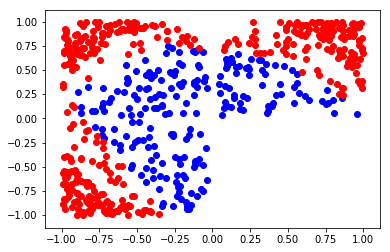

duration: 0.584033266703minutes, count updates: 14


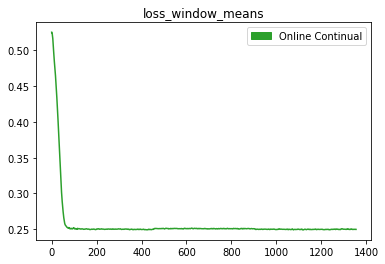

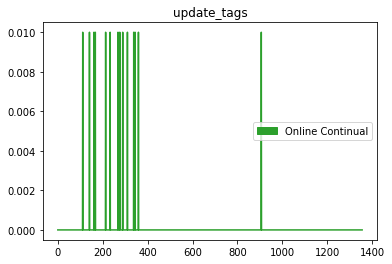

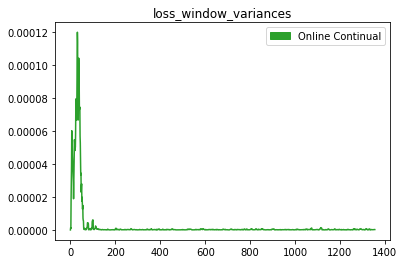

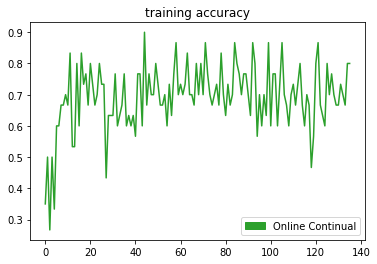

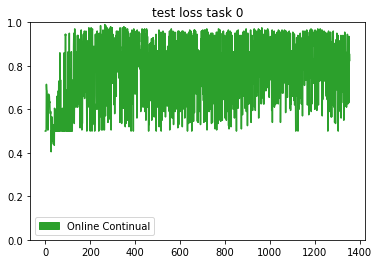

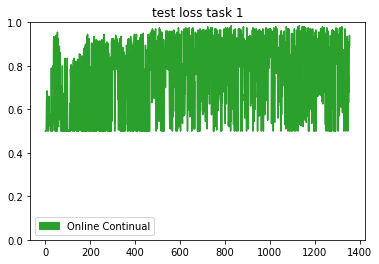

Online Continual: 86.0




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online Continual
train 14.9564008713 vs total 14.9564008713
train 15.105884552 vs total 15.1338567734
train 14.9384527206 vs total 15.0245437622
train 15.0019159317 vs total 15.0163841248
train 14.9832324982 vs total 14.9963207245
train 15.0316457748 vs total 15.0357370377
train 14.9322347641 vs total 14.9343347549


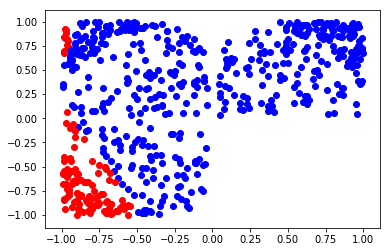

duration: 0.539708065987minutes, count updates: 4


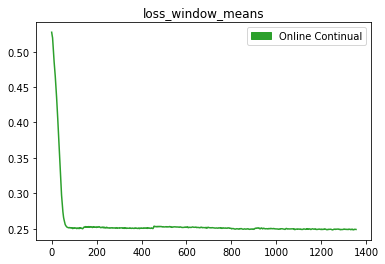

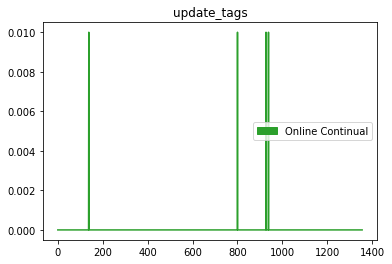

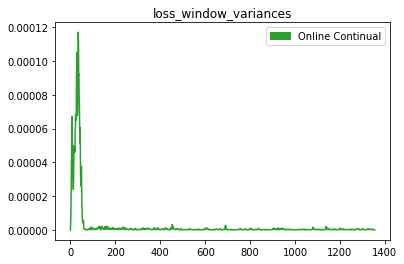

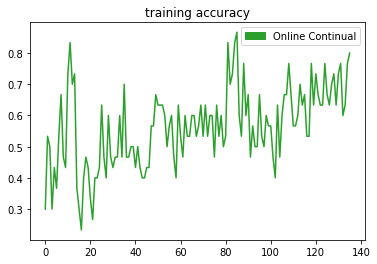

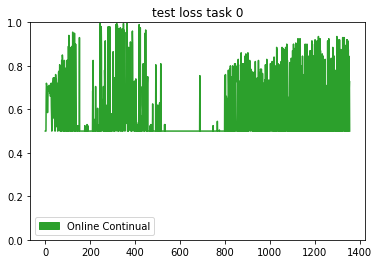

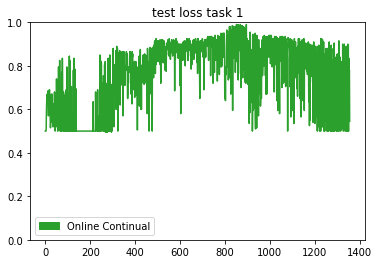

Online Continual: 64.0




Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online Continual
train 14.8092737198 vs total 14.8092737198
train 14.9882440567 vs total 15.0460567474
train 14.9722614288 vs total 15.0134325027
train 14.893784523 vs total 14.9265651703
train 14.9273099899 vs total 14.9363622665
train 14.8731460571 vs total 14.9080629349
train 14.9664382935 vs total 14.9673290253
train 15.0058031082 vs total 15.0104837418
train 14.9945144653 vs total 14.9990158081
train 15.0549793243 vs total 15.0561914444
train 14.9914264679 vs total 15.0017375946
train 15.0519332886 vs total 15.053311348
train 14.9737663269 vs total 14.9830236435
train 14.9516372681 vs total 14.9910202026
train 14.9654626846 vs total 14.9685544968
train 15.1824197769 vs total 15.194562912
train 14.9176359177 vs total 14.9358987808
train 14.9102993011 vs total 15.017824173
train 15.0023508072 vs 

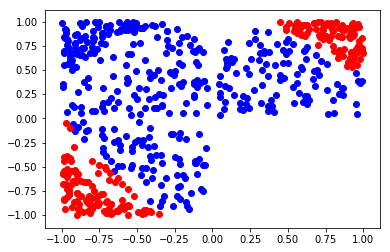

duration: 0.636209102472minutes, count updates: 10


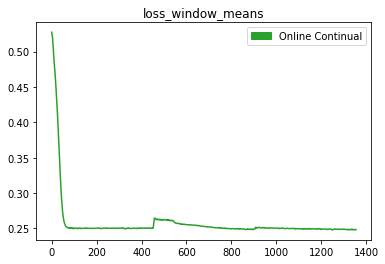

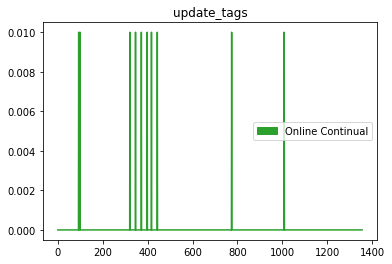

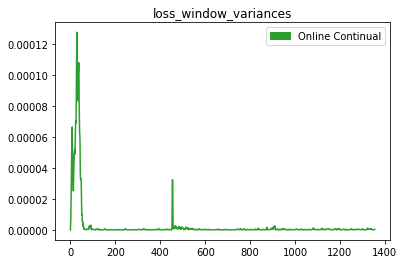

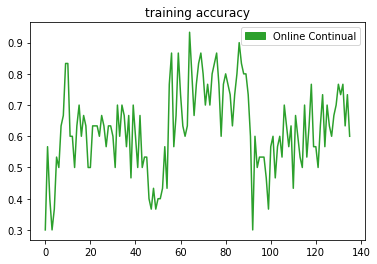

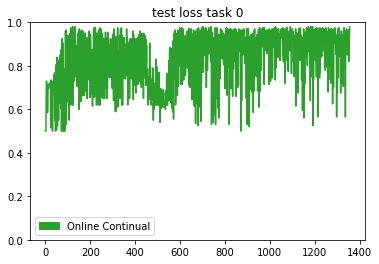

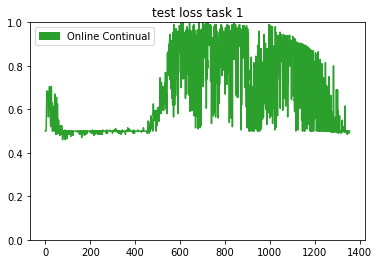

Online Continual: 80.0
duration: 125.258326054


In [105]:
##################################
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.25
loss_window_variance_threshold=0.000005
MAS_weight=5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
tags=['Online No Hardbuffer','Online','Online Continual']

start_exp=time.time()
alpha=0.9
meta_experiment(tags)
alpha=0.99
meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)

0:proportion positive/total=0.5
1:proportion positive/total=0.5
2:proportion positive/total=0.5
sampling data duration:  7.07071709633




Start experiment with alpha: 0.9

Online No Hardbuffer


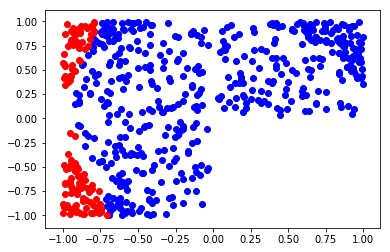

duration: 0.138871936003minutes, count updates: 0

Online


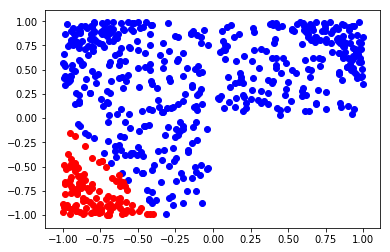

duration: 0.144402885437minutes, count updates: 0

Online Continual
train 29.9045600891 vs total 29.9045600891
train 30.172908783 vs total 30.1863498688
train 29.9234428406 vs total 29.9537220001
train 30.1267433167 vs total 30.1302127838
train 29.8162689209 vs total 29.8459262848
train 30.0944423676 vs total 30.1261940002


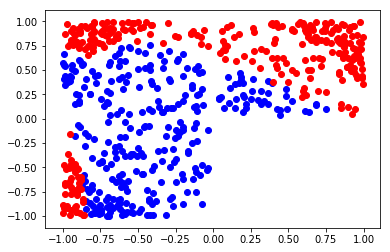

duration: 0.259614515305minutes, count updates: 3


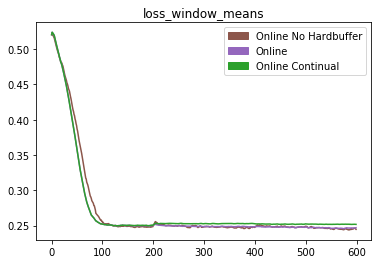

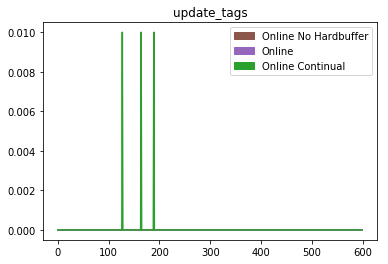

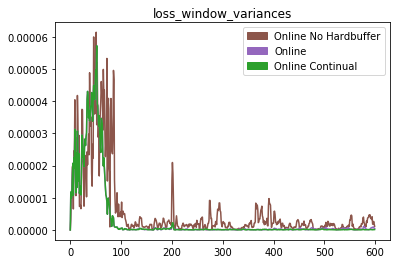

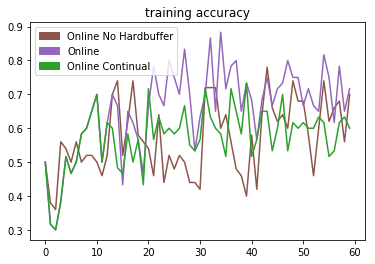

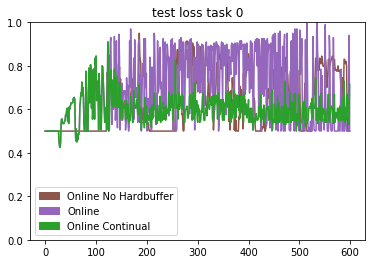

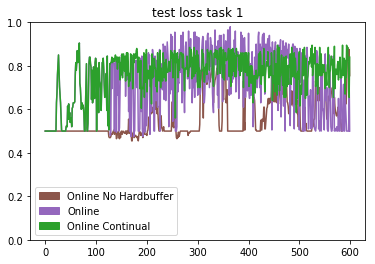

Online No Hardbuffer: 70.1666666667
Online: 63.8333333333
Online Continual: 76.1666666667
0:proportion positive/total=0.5
1:proportion positive/total=0.5
2:proportion positive/total=0.5
sampling data duration:  7.54558491707




Start experiment with alpha: 0.99

Online No Hardbuffer


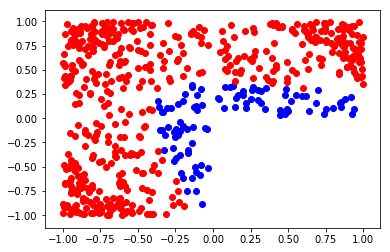

duration: 0.162630081177minutes, count updates: 0

Online


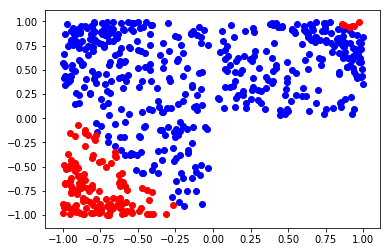

duration: 0.139753599962minutes, count updates: 0

Online Continual
train 29.9714660645 vs total 29.9714660645
train 30.0891895294 vs total 30.0908336639
train 29.9219112396 vs total 29.9312610626
train 29.9930438995 vs total 30.019449234


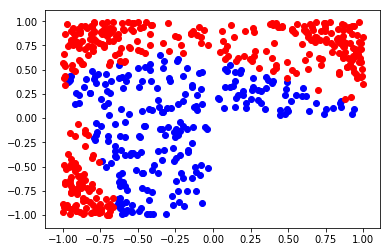

duration: 0.26132371823minutes, count updates: 2


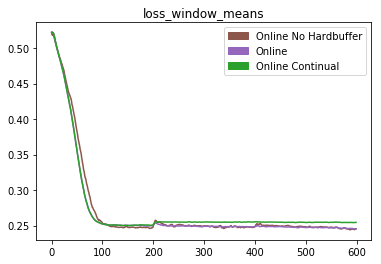

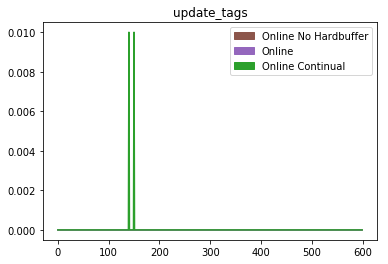

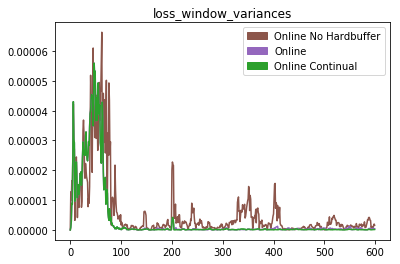

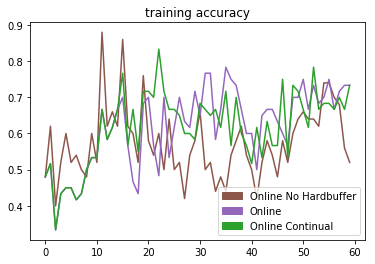

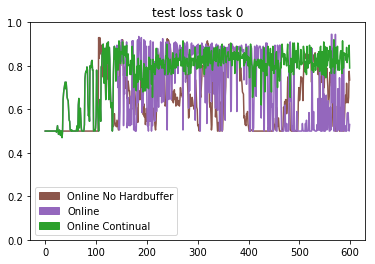

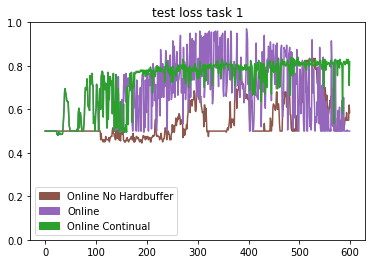

Online No Hardbuffer: 66.3333333333
Online: 62.3333333333
Online Continual: 81.8333333333
0:proportion positive/total=0.5
1:proportion positive/total=0.5
2:proportion positive/total=0.5
sampling data duration:  6.56310892105




Start experiment with alpha: 1.0

Online No Hardbuffer


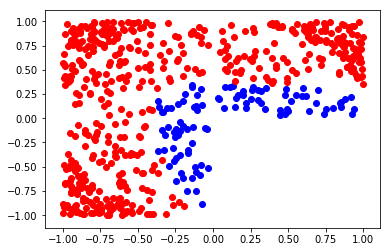

duration: 0.128924349944minutes, count updates: 0

Online


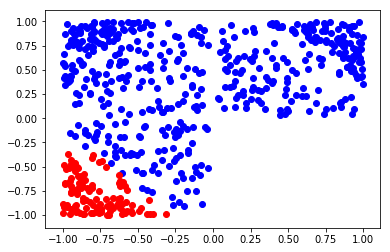

duration: 0.153317169348minutes, count updates: 0

Online Continual
train 29.9890136719 vs total 29.9890136719
train 31.1170635223 vs total 31.1400489807


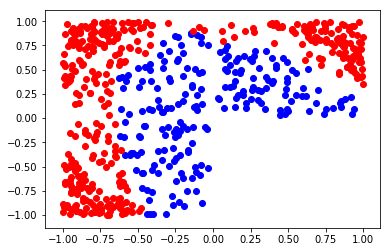

duration: 0.266728766759minutes, count updates: 1


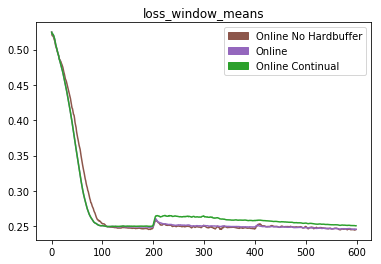

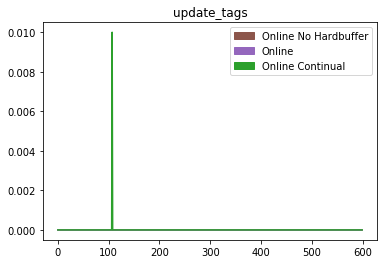

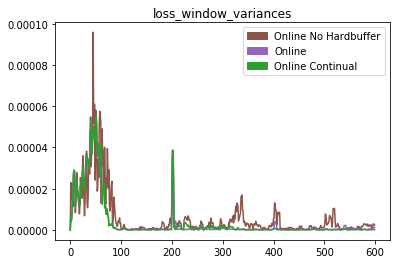

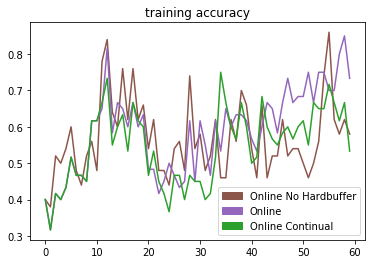

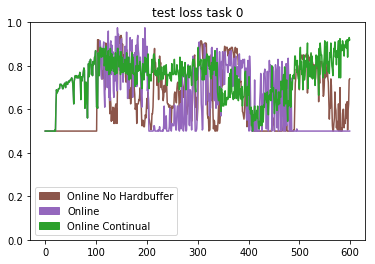

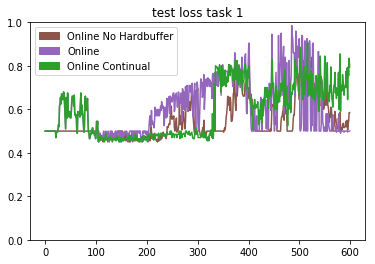

Online No Hardbuffer: 66.8333333333
Online: 64.5
Online Continual: 83.8333333333
duration: 129.294191122


In [179]:
###############################
# CHANGE:  increase batchsize #
###############################
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
distribution_offset=0.03
discriminator_offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00003
ntrain=10000
batch_size=50
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.25
loss_window_variance_threshold=0.000005
MAS_weight=5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
tags=['Online No Hardbuffer','Online','Online Continual']

start_exp=time.time()
#alpha=0.25
#sample_data()
#meta_experiment(tags)
alpha=0.9
sample_data()
meta_experiment(tags)
alpha=0.99
sample_data()
meta_experiment(tags)
alpha=1.0
sample_data()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online No Hardbuffer


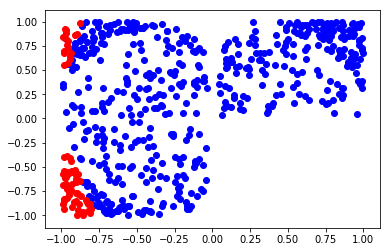

duration: 0.239259330432minutes, count updates: 0

Online


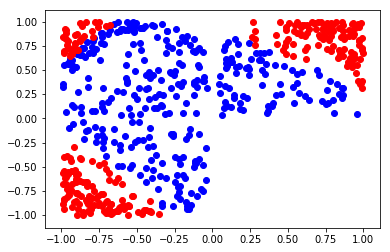

duration: 0.246996951103minutes, count updates: 0

Online Continual
train 14.9882936478 vs total 14.9882936478
train 15.0249843597 vs total 15.0318479538
train 15.0038232803 vs total 15.019033432
train 15.0279178619 vs total 15.0309534073
train 14.9557962418 vs total 14.9674310684
train 15.0397577286 vs total 15.0516214371
train 14.975522995 vs total 14.9820747375
train 15.0147752762 vs total 15.0183801651
train 14.9653282166 vs total 14.96895504


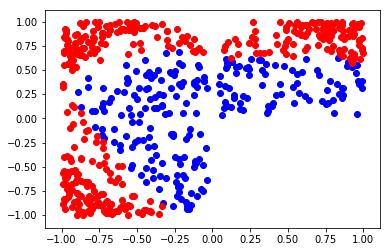

duration: 0.456394565105minutes, count updates: 5


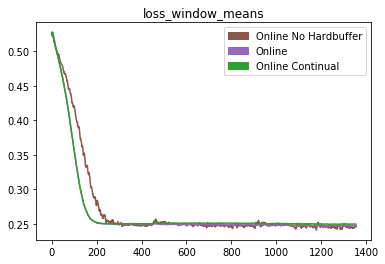

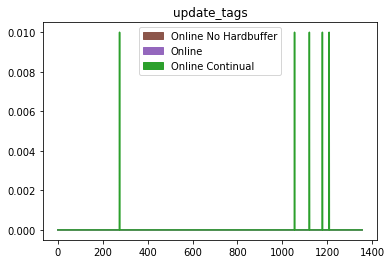

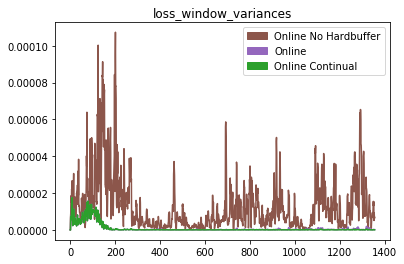

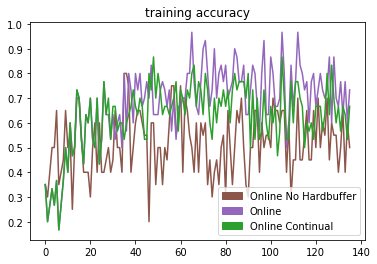

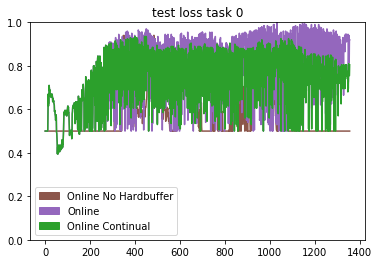

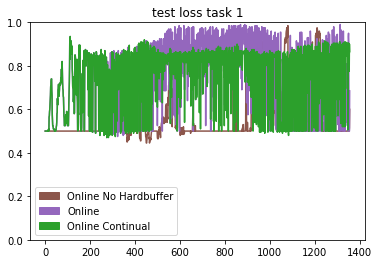

Online No Hardbuffer: 62.3333333333
Online: 84.3333333333
Online Continual: 84.1666666667




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online No Hardbuffer


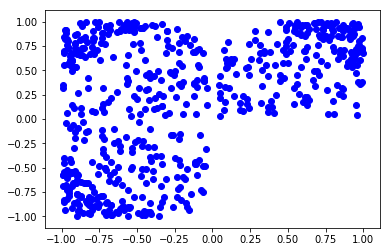

duration: 0.244477665424minutes, count updates: 0

Online


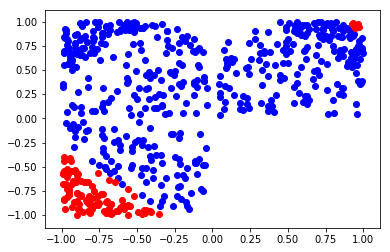

duration: 0.24784886837minutes, count updates: 0

Online Continual
train 14.9326314926 vs total 14.9326314926
train 15.0352954865 vs total 15.0372648239


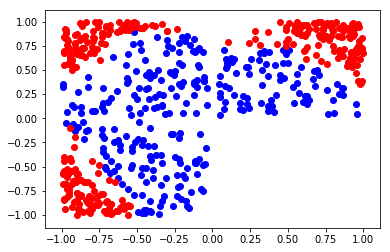

duration: 0.445184532801minutes, count updates: 1


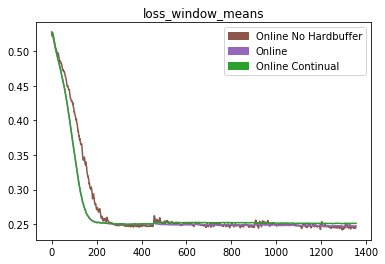

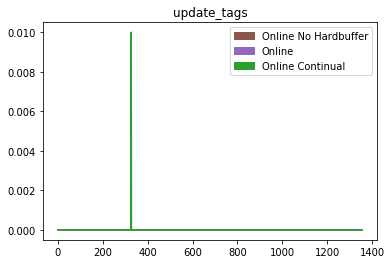

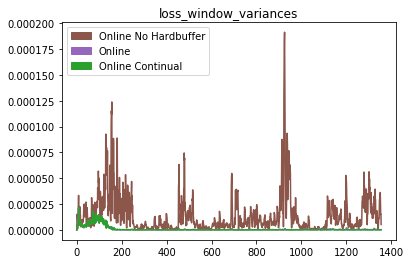

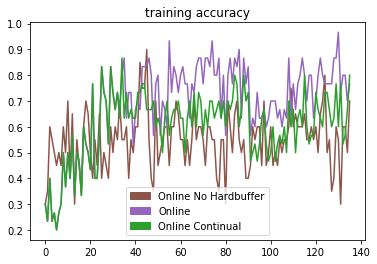

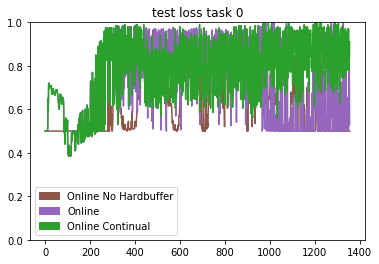

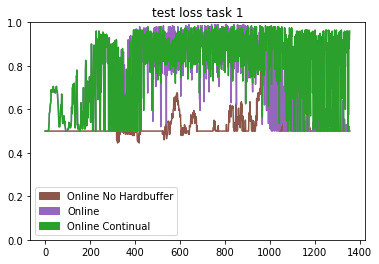

Online No Hardbuffer: 50.0
Online: 66.8333333333
Online Continual: 92.8333333333




Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online No Hardbuffer


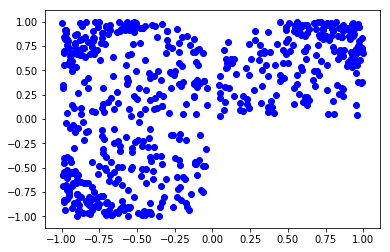

duration: 0.270333484809minutes, count updates: 0

Online


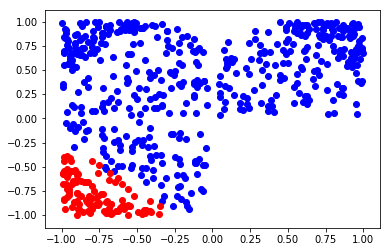

duration: 0.248899284999minutes, count updates: 0

Online Continual
train 14.9608488083 vs total 14.9608488083
train 15.0552415848 vs total 15.0605173111


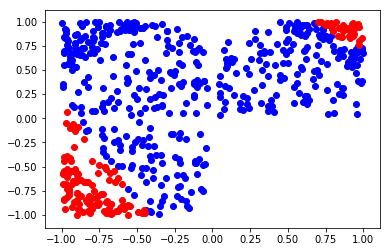

duration: 0.449485317866minutes, count updates: 1


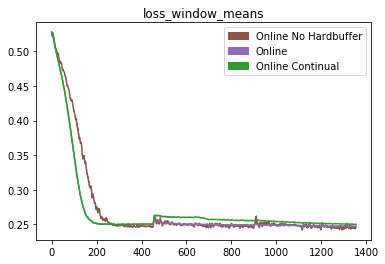

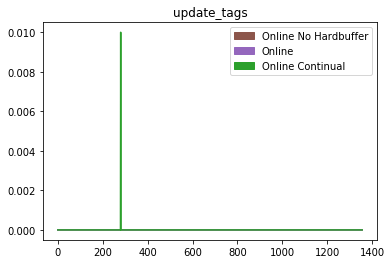

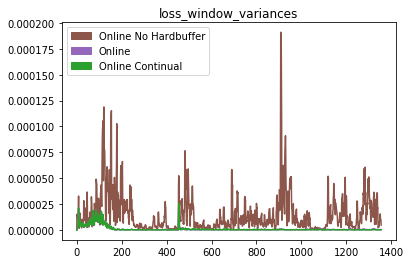

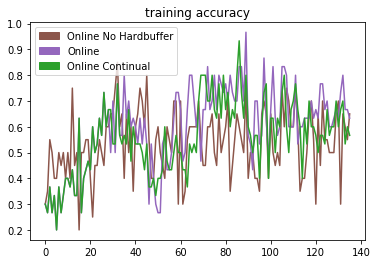

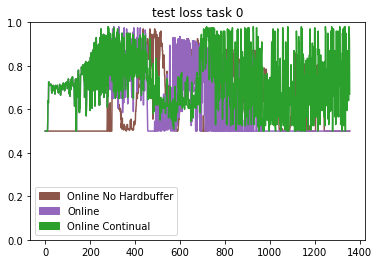

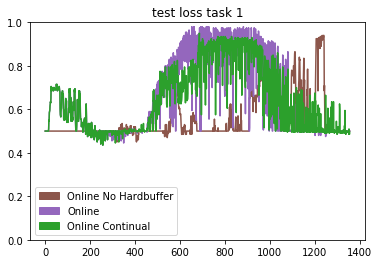

Online No Hardbuffer: 50.0
Online: 64.6666666667
Online Continual: 68.1666666667
duration: 190.415903091


In [106]:
##################################
# CHANGE:  decrease learning rate#
# 0.00009 --> 0.00003
##################################
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00003
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.25
loss_window_variance_threshold=0.000005
MAS_weight=5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
tags=['Online No Hardbuffer','Online','Online Continual']

start_exp=time.time()
alpha=0.9
meta_experiment(tags)
alpha=0.99
meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online No Hardbuffer


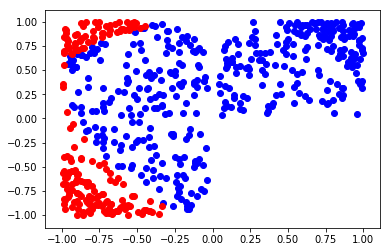

duration: 0.284084117413minutes, count updates: 0

Online


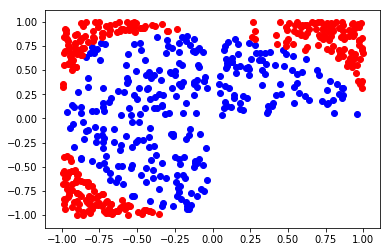

duration: 0.265490619342minutes, count updates: 0

Online Continual
train 14.8510713577 vs total 14.8510713577
train 15.002122879 vs total 15.101978302
train 14.9845094681 vs total 15.0152139664
train 15.0437278748 vs total 15.0468702316
train 14.9887609482 vs total 14.9936285019
train 14.909365654 vs total 14.9417362213
train 14.9294719696 vs total 14.9457798004
train 14.8626775742 vs total 14.9044818878
train 14.9193820953 vs total 14.9275074005
train 14.8457641602 vs total 14.9002218246
train 14.9744319916 vs total 14.986073494
train 14.907699585 vs total 14.928273201
train 14.9188308716 vs total 14.9409923553
train 14.9973621368 vs total 15.0051660538
train 15.0009508133 vs total 15.021074295
train 14.9243574142 vs total 14.9488458633
train 14.9567279816 vs total 14.962682724
train 14.9737415314 vs total 14.9781246185
train 14.9457235336 vs total 14.9515533447
train 15.0096130371 vs total 15.0197210312
train 14.9475946426 vs total 14.9600248337
train 14.8962879181 vs total 14.96498

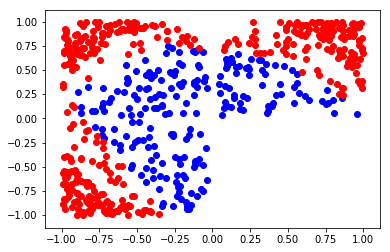

duration: 0.555176615715minutes, count updates: 14


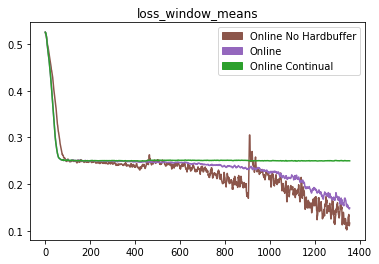

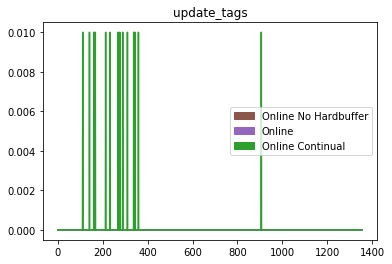

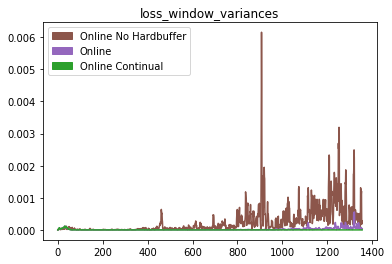

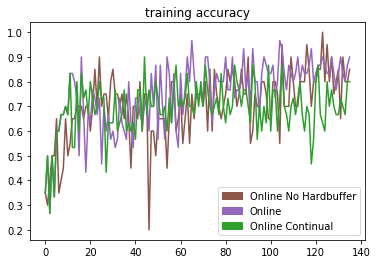

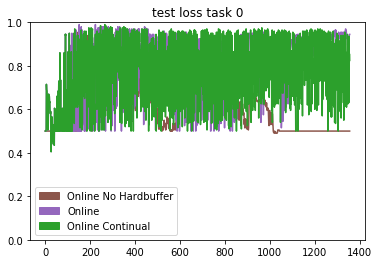

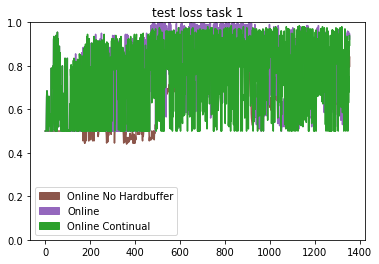

Online No Hardbuffer: 74.8333333333
Online: 96.3333333333
Online Continual: 86.0




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online No Hardbuffer


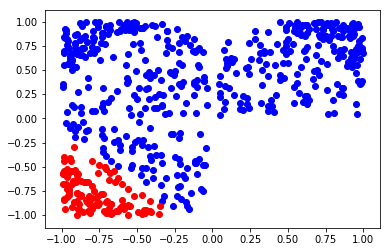

duration: 0.287516748905minutes, count updates: 0

Online


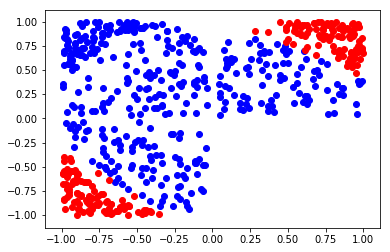

duration: 0.28491820097minutes, count updates: 0

Online Continual
train 14.9564008713 vs total 14.9564008713
train 15.105884552 vs total 15.1338567734
train 14.9384527206 vs total 15.0245437622
train 15.0019159317 vs total 15.0163841248
train 14.9832324982 vs total 14.9963207245
train 15.0316457748 vs total 15.0357370377
train 14.9322347641 vs total 14.9343347549


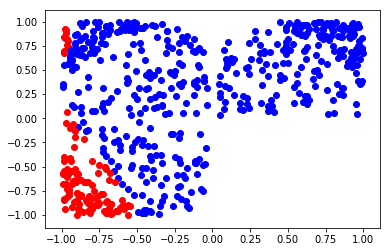

duration: 0.596664349238minutes, count updates: 4


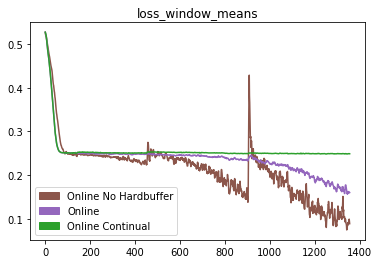

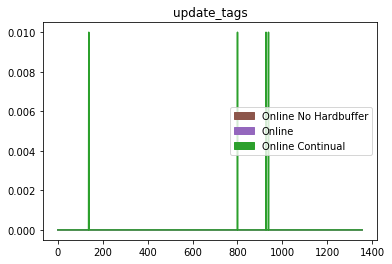

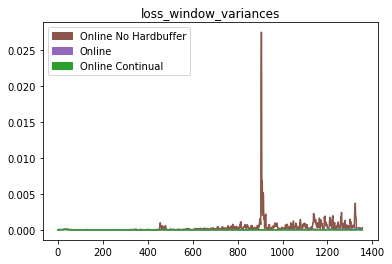

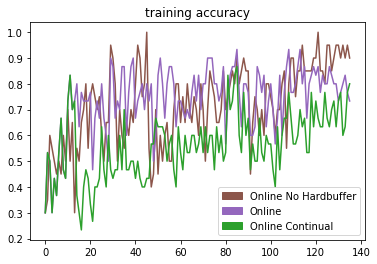

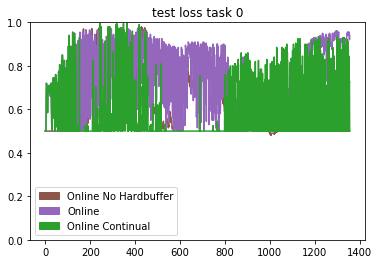

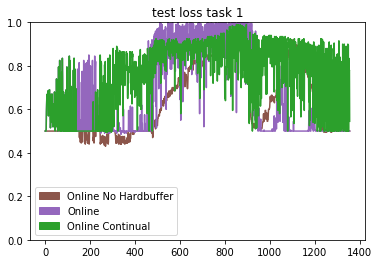

Online No Hardbuffer: 63.6666666667
Online: 80.8333333333
Online Continual: 64.0




Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online No Hardbuffer


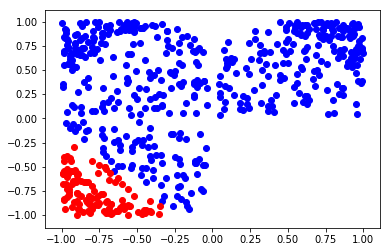

duration: 0.272635551294minutes, count updates: 0

Online


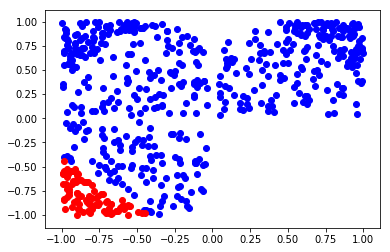

duration: 0.359079964956minutes, count updates: 0

Online Continual
train 14.8092737198 vs total 14.8092737198
train 14.9882440567 vs total 15.0460567474
train 14.9722614288 vs total 15.0134325027
train 14.893784523 vs total 14.9265651703
train 14.9273099899 vs total 14.9363622665
train 14.8731460571 vs total 14.9080629349
train 14.9664382935 vs total 14.9673290253
train 15.0058031082 vs total 15.0104837418
train 14.9945144653 vs total 14.9990158081
train 15.0549793243 vs total 15.0561914444
train 14.9914264679 vs total 15.0017375946
train 15.0519332886 vs total 15.053311348
train 14.9737663269 vs total 14.9830236435
train 14.9516372681 vs total 14.9910202026
train 14.9654626846 vs total 14.9685544968
train 15.1824197769 vs total 15.194562912
train 14.9176359177 vs total 14.9358987808
train 14.9102993011 vs total 15.017824173
train 15.0023508072 vs total 15.0057144165


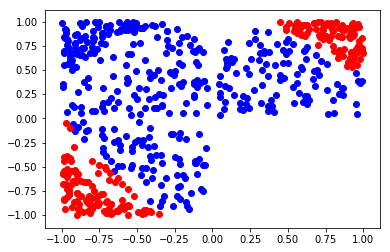

duration: 0.66545163393minutes, count updates: 10


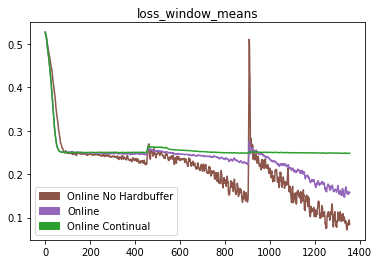

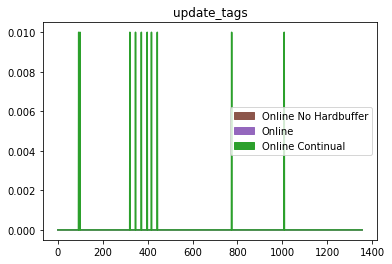

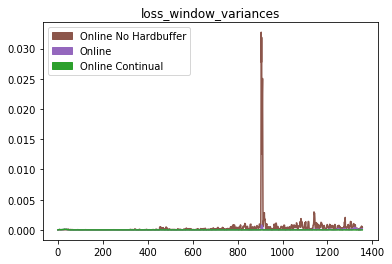

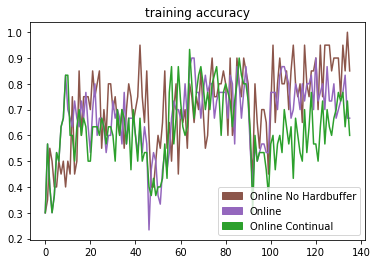

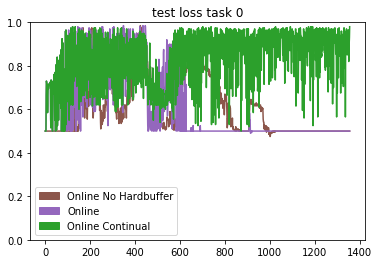

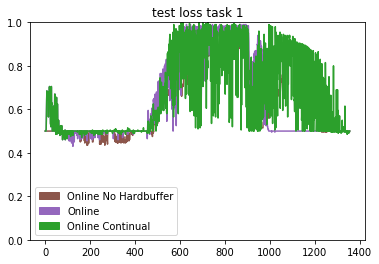

Online No Hardbuffer: 64.0
Online: 65.0
Online Continual: 80.0
duration: 238.654556036


In [103]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.25
loss_window_variance_threshold=0.000005
MAS_weight=5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
tags=['Online No Hardbuffer','Online','Online Continual']

start_exp=time.time()
alpha=0.9
meta_experiment(tags)
alpha=0.99
meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online Continual
train 14.9564008713 vs total 14.9564008713
train 15.1336555481 vs total 15.1500759125


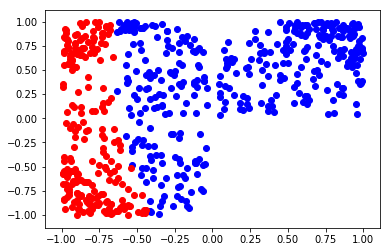

duration: 0.546211000284minutes, count updates: 1


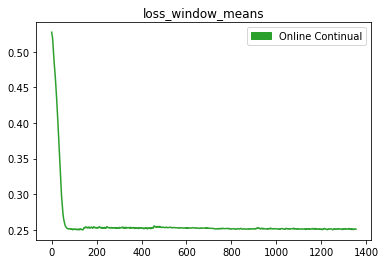

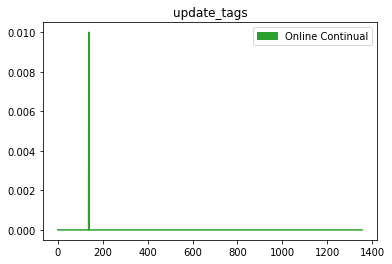

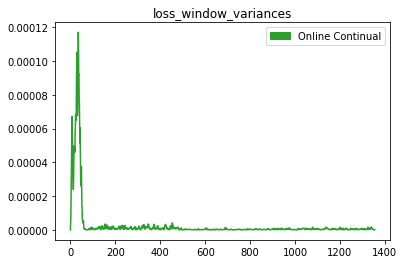

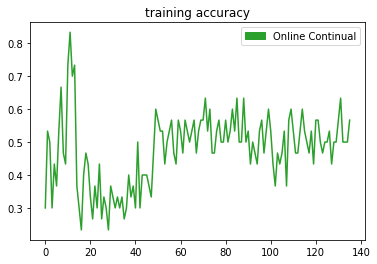

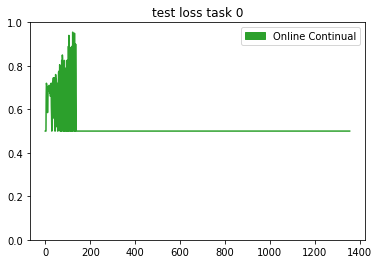

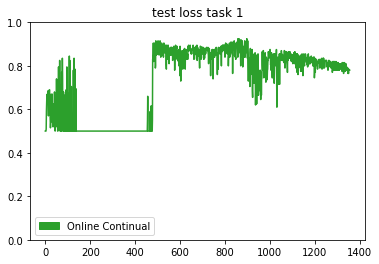

Online Continual: 68.6666666667
duration: 39.9775838852


In [90]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.25
loss_window_variance_threshold=0.000005
MAS_weight=5

#tags=['Online Continual','Online Continual No Hardbuffer']
tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
#tags=['Online No Hardbuffer','Online']

start_exp=time.time()
#alpha=0.9
#meta_experiment(tags)
#alpha=0.99
#meta_experiment(tags)
#alpha=1.0
#meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online No Hardbuffer


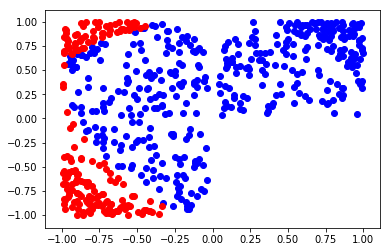

duration: 0.289594519138minutes, count updates: 0

Online


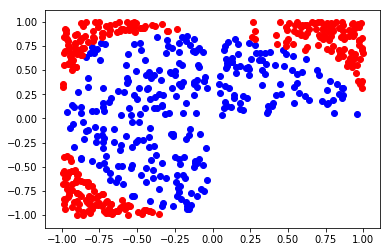

duration: 0.296442302068minutes, count updates: 0


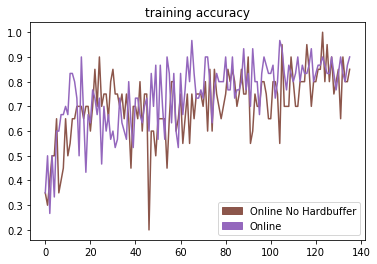

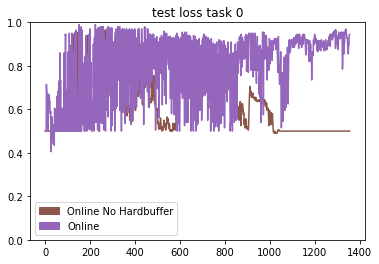

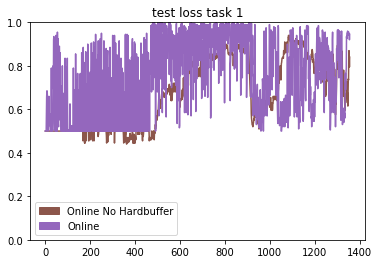

Online No Hardbuffer: 74.8333333333
Online: 96.3333333333




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online No Hardbuffer


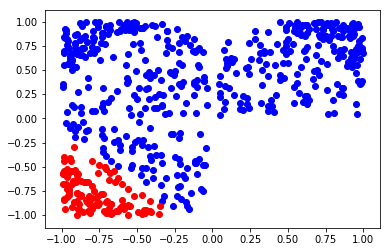

duration: 0.274504967531minutes, count updates: 0

Online


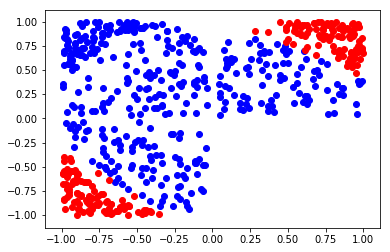

duration: 0.306922447681minutes, count updates: 0


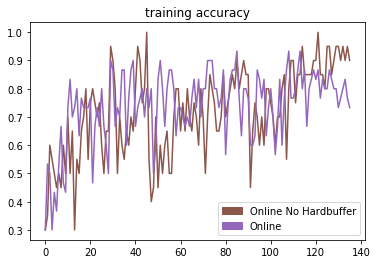

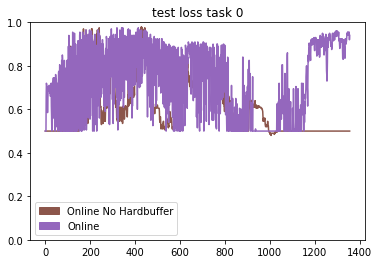

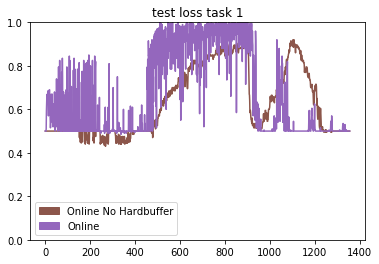

Online No Hardbuffer: 63.6666666667
Online: 80.8333333333
duration: 81.9850988388


In [71]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=3
loss_window_mean_threshold=0.24
loss_window_variance_threshold=0.00003
MAS_weight=0.5

tags=['Online No Hardbuffer','Online']

start_exp=time.time()
alpha=0.9
meta_experiment(tags)
alpha=0.99
meta_experiment(tags)
#alpha=1.0
#meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online Continual
duration: 0.408893585205minutes, count updates: 29

Online
duration: 0.278206066291minutes, count updates: 0

Online No Hardbuffer
duration: 0.297891267141minutes, count updates: 0


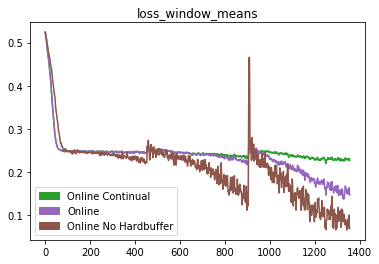

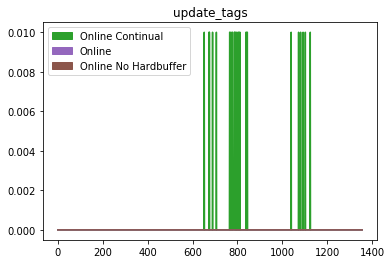

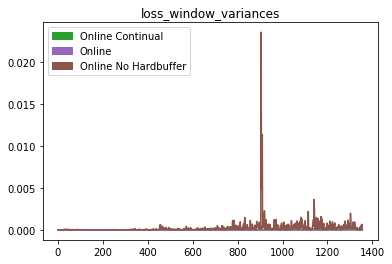

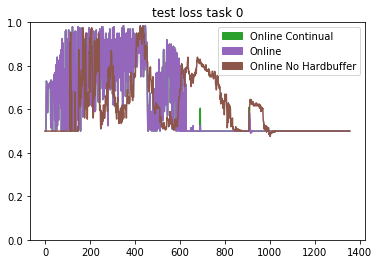

Online Continual: 66.0
Online: 65.0
Online No Hardbuffer: 64.0
duration: 67.4615840912


In [73]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 20
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=3
loss_window_mean_threshold=0.24
loss_window_variance_threshold=0.00003
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']
tags=['Online Continual','Online','Online No Hardbuffer']

start_exp=time.time()
#alpha=0.9
#meta_experiment(tags)
#alpha=0.99
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online Continual
duration: 0.554300880432minutes, count updates: 8


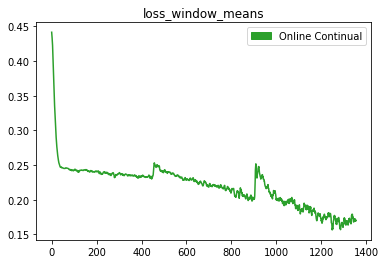

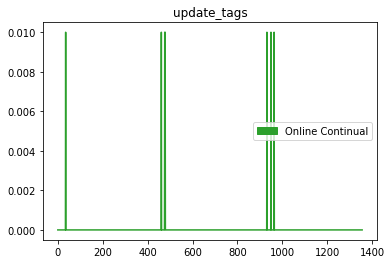

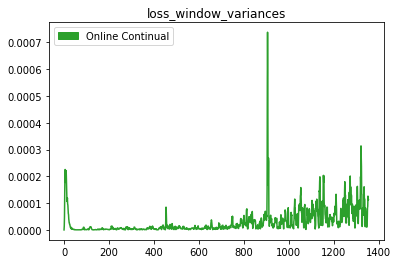

{'Online Continual': [0.44155878, 0.43772584, 0.43320474, 0.42772847, 0.42252356, 0.41263062, 0.40239412, 0.392304, 0.38257226, 0.37216136, 0.36258483, 0.3532918, 0.34415254, 0.33590084, 0.32883278, 0.32090896, 0.31405598, 0.3072275, 0.30077535, 0.29461154, 0.2898702, 0.28455356, 0.28032863, 0.2764414, 0.27294475, 0.26938075, 0.26640534, 0.2637458, 0.26113933, 0.25886282, 0.25702602, 0.25487316, 0.25343475, 0.2523514, 0.25140944, 0.24967816, 0.24958558, 0.24821004, 0.24731925, 0.24711898, 0.24709661, 0.24679771, 0.24687532, 0.24714668, 0.24651599, 0.24680743, 0.2461313, 0.24602637, 0.2457689, 0.24577329, 0.24571638, 0.24576755, 0.24567392, 0.24538219, 0.2452395, 0.24520858, 0.24515744, 0.245242, 0.24522564, 0.24521847, 0.2452069, 0.24563181, 0.24588594, 0.24606888, 0.24604082, 0.24603291, 0.24563512, 0.24557373, 0.2454706, 0.24550943, 0.245458, 0.24552897, 0.24536344, 0.2450532, 0.24500756, 0.2445068, 0.24427927, 0.24417667, 0.24358448, 0.24361315, 0.24376078, 0.2433627, 0.24292068, 0.

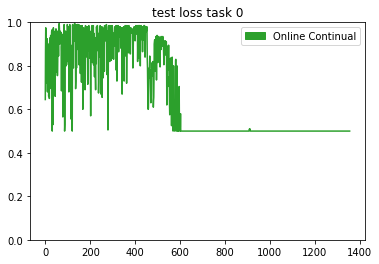

Online Continual: 66.5
duration: 39.1647789478


In [63]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 40
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=5
loss_window_mean_threshold=0.24
loss_window_variance_threshold=0.00001
MAS_weight=0.1

#tags=['Online Continual','Online Continual No Hardbuffer']
tags=['Online Continual']
#tags=['Online']
#tags=['Online No Hardbuffer']

start_exp=time.time()
#alpha=0.9
#meta_experiment(tags)
#alpha=0.99
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online No Hardbuffer
duration: 0.31952316761minutes, count updates: 0


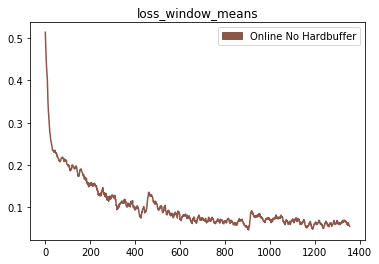

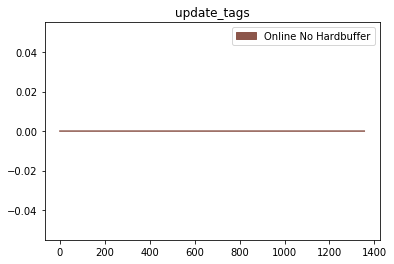

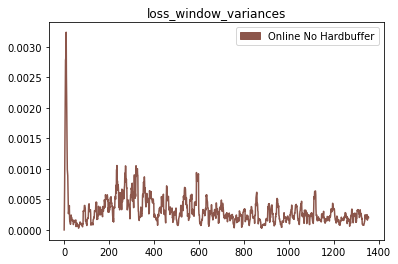

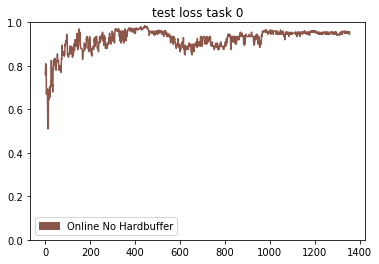

Online No Hardbuffer: 96.3333333333




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online No Hardbuffer
duration: 0.357213302453minutes, count updates: 0


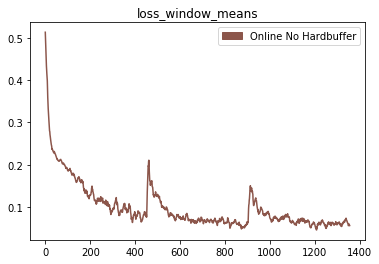

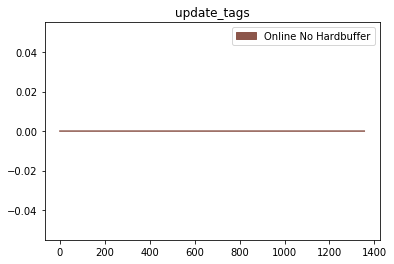

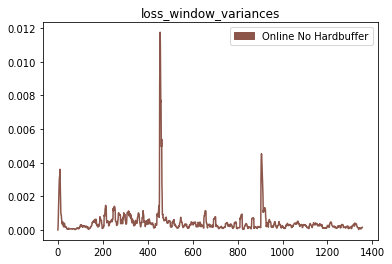

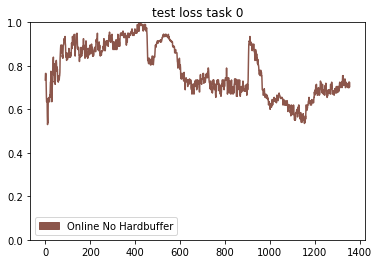

Online No Hardbuffer: 74.1666666667




Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online No Hardbuffer
duration: 0.333863631884minutes, count updates: 0


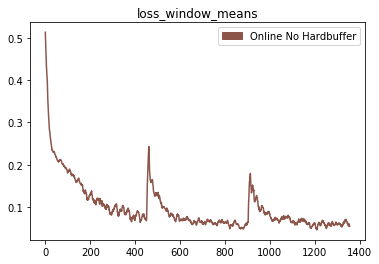

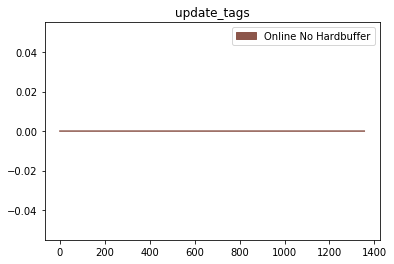

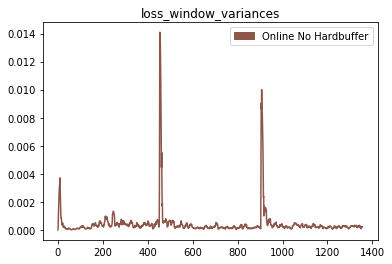

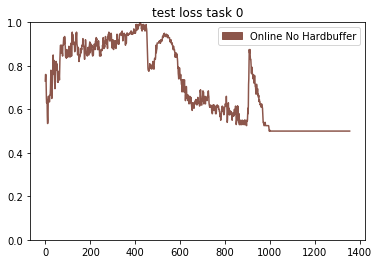

Online No Hardbuffer: 66.3333333333
duration: 77.2249798775


In [67]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 100
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online']
tags=['Online No Hardbuffer']

start_exp=time.time()
#alpha=0.9
#meta_experiment(tags)
#alpha=0.99
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.9
0:proportion positive/total=0.506291390728
1:proportion positive/total=0.507305733894
2:proportion positive/total=0.513002102468

Online
duration: 0.375734698772minutes, count updates: 0


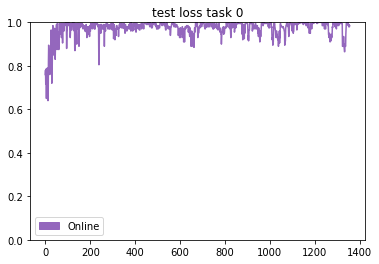

Online: 99.5




Start experiment with alpha: 0.99
0:proportion positive/total=0.507682104565
1:proportion positive/total=0.505752212389
2:proportion positive/total=0.514033149171

Online
duration: 0.415246633689minutes, count updates: 0


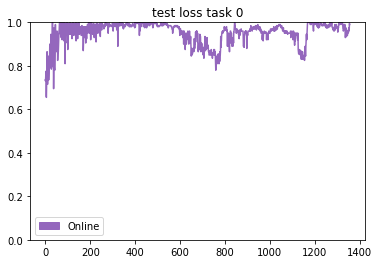

Online: 99.6666666667




Start experiment with alpha: 1.0
0:proportion positive/total=0.507624309392
1:proportion positive/total=0.506693218276
2:proportion positive/total=0.513152077807

Online
duration: 0.391913100084minutes, count updates: 0


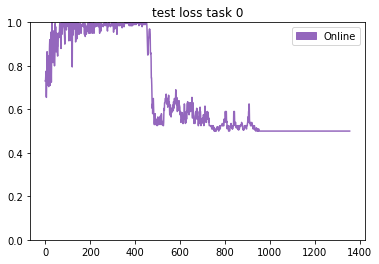

Online: 74.6666666667
duration: 83.8008868694


In [69]:
########
# DATA #
########
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
#offset=0.1
offset=0.03
ntest=200
############
# TRAINING #
############
learning_rate=0.00009
ntrain=10000
batch_size=20
hidden_units = 100
gradient_steps = 10
seed=512
ntasks=3
##############
# OUR METHOD #
##############
hard_batch_size=10
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer']
tags=['Online']
#tags=['Online No Hardbuffer']

start_exp=time.time()
alpha=0.9
meta_experiment(tags)
#alpha=0.99
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online Continual


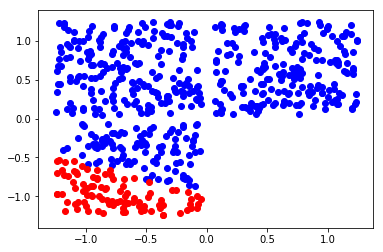

duration: 0.170007900397minutes, count updates: 0

Online Continual No Hardbuffer


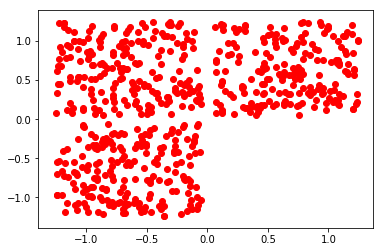

duration: 0.174108600616minutes, count updates: 0


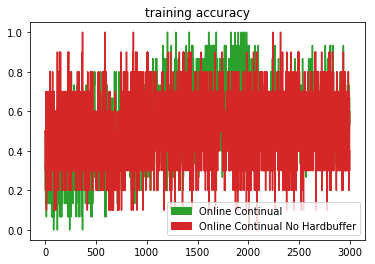

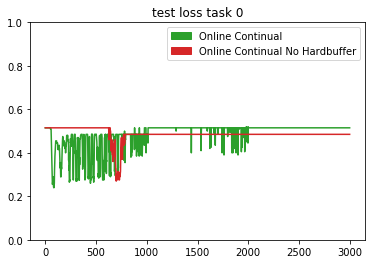

Online Continual: 63.1666666667
Online Continual No Hardbuffer: 51.3333333333
duration: 22.7475700378


In [35]:
dim=2
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.0001
ntrain=10000
batch_size=10
hard_batch_size=5
hidden_units = 10
gradient_steps = 1
seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

tags=['Online Continual','Online Continual No Hardbuffer']
#tags=['Online','Online No Hardbuffer']


start_exp=time.time()

#alpha=1.0
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.75

Online


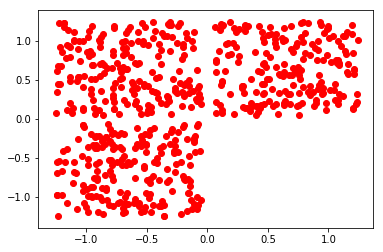

duration: 0.156858336926minutes, count updates: 0

Online No Hardbuffer


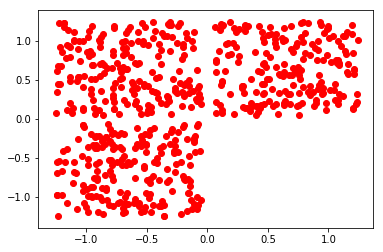

duration: 0.157054499785minutes, count updates: 0


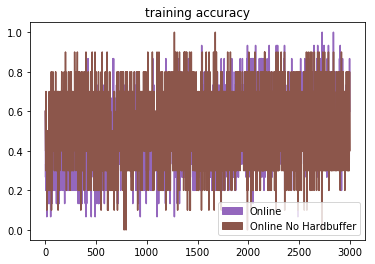

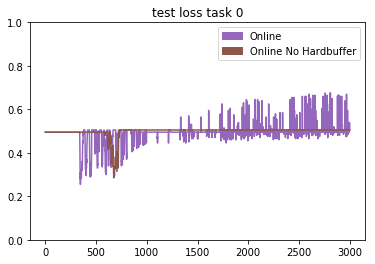

Online: 50.3333333333
Online No Hardbuffer: 50.3333333333




Start experiment with alpha: 0.5

Online


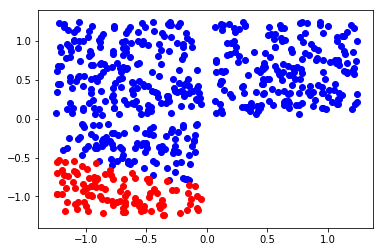

duration: 0.159999235471minutes, count updates: 0

Online No Hardbuffer


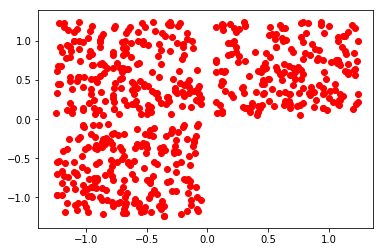

duration: 0.153228068352minutes, count updates: 0


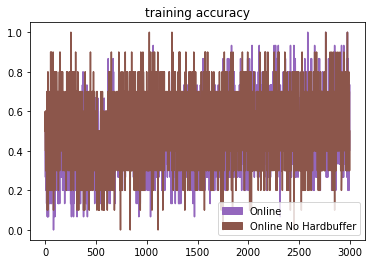

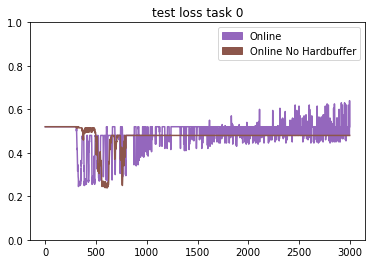

Online: 62.5
Online No Hardbuffer: 51.3333333333
duration: 42.1418209076


In [36]:
dim=2
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.0001
ntrain=10000
batch_size=10
hard_batch_size=5
hidden_units = 10
gradient_steps = 1
seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online','Online No Hardbuffer']


start_exp=time.time()

#alpha=1.0
#meta_experiment(tags)
alpha=0.75
meta_experiment(tags)
alpha=0.5
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online


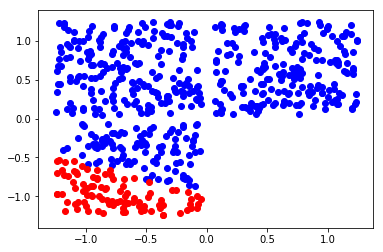

duration: 0.194567934672minutes, count updates: 0

Online No Hardbuffer


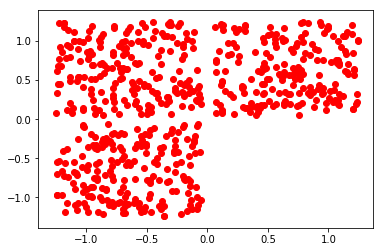

duration: 0.165612983704minutes, count updates: 0


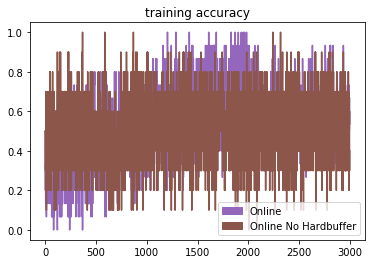

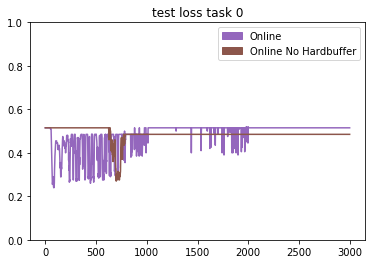

Online: 63.1666666667
Online No Hardbuffer: 51.3333333333
duration: 23.8302528858


In [34]:
dim=2
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.0001
ntrain=10000
batch_size=10
hard_batch_size=5
hidden_units = 10
gradient_steps = 1
seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online','Online No Hardbuffer']


start_exp=time.time()

#alpha=1.0
#meta_experiment(tags)
alpha=1.0
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)
#print "duration: "+str(time.time()-start_exp)
#start_exp=time.time()
#alpha=0.5
#meta_experiment(tags)
#print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online No Hardbuffer
duration: 0.157946332296minutes, count updates: 0

Online Continual No Hardbuffer
duration: 0.235256048044minutes, count updates: 1


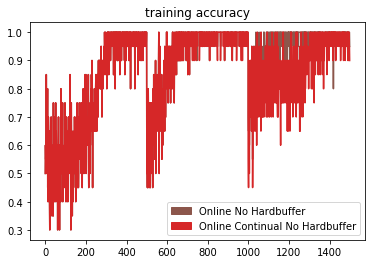

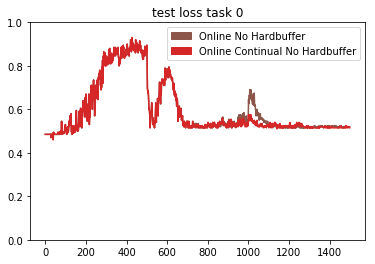

Online No Hardbuffer: 59.3333333333
Online Continual No Hardbuffer: 75.1666666667
duration: 41.0971331596


In [30]:
dim=20
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.0006
ntrain=10000
batch_size=20
hidden_units = 10
gradient_steps = 5

seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online No Hardbuffer','Online Continual No Hardbuffer']


start_exp=time.time()
alpha=1.0
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)
#start_exp=time.time()
#alpha=0.75
#meta_experiment(tags)
#print "duration: "+str(time.time()-start_exp)
#start_exp=time.time()
#alpha=0.5
#meta_experiment(tags)
#print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1

Online No Hardbuffer


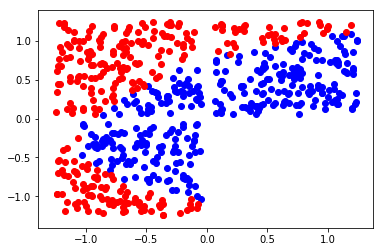

duration: 1.37620523373minutes, count updates: 0


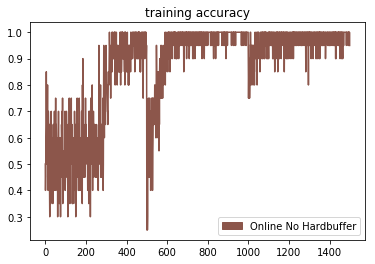

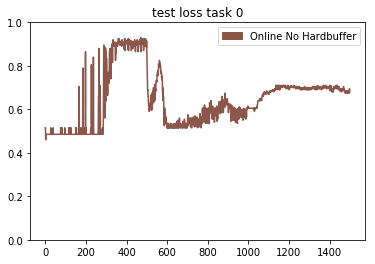

Online No Hardbuffer: 80.8333333333




Start experiment with alpha: 0.75

Online No Hardbuffer


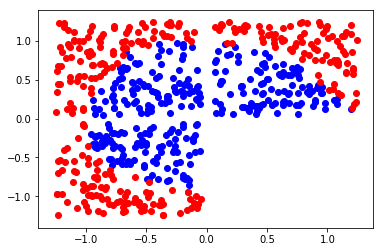

duration: 1.72997831504minutes, count updates: 0


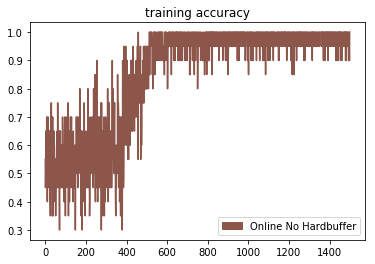

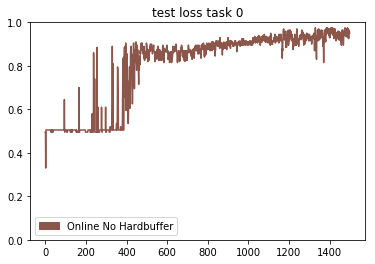

Online No Hardbuffer: 96.8333333333




Start experiment with alpha: 0.5

Online No Hardbuffer


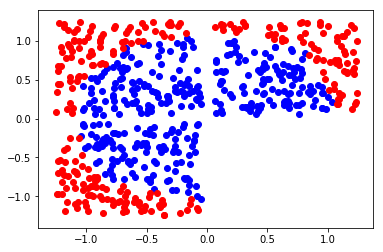

duration: 1.60993314981minutes, count updates: 0


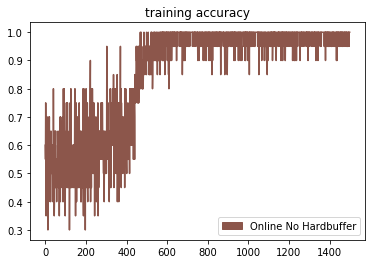

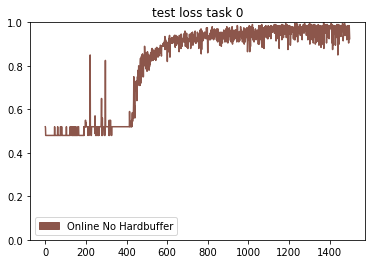

Online No Hardbuffer: 91.0
duration: 345.55798912


In [38]:
dim=2
var=1 #0.1 #variance of noise over uninformative dimensions

learning_rate=0.001
ntrain=10000
batch_size=20
hidden_units = 10
gradient_steps = 5

seed=512
ntasks=3
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
MAS_weight=0.5

#tags=['Online Continual','Online Continual No Hardbuffer','Online','Online No Hardbuffer']
tags=['Online No Hardbuffer']


start_exp=time.time()
alpha=1
meta_experiment(tags)
alpha=0.75
meta_experiment(tags)
alpha=0.5
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)






Start experiment with alpha: 1.0

Online Continual
duration: 2.19031113386minutes, count updates: 25

Online Continual No Hardbuffer
duration: 0.692833264669minutes, count updates: 1

Online
duration: 0.971847399076minutes, count updates: 0

Online No Hardbuffer
duration: 0.472683131695minutes, count updates: 0


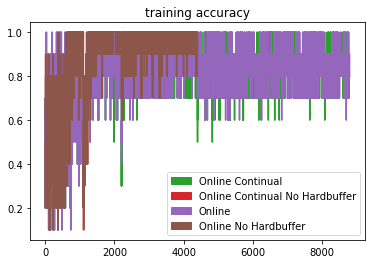

Online Continual: 95.875
Online Continual No Hardbuffer: 90.75
Online: 90.625
Online No Hardbuffer: 87.875
duration: 261.765405893




Start experiment with alpha: 0.9

Online Continual
duration: 1.96769885222minutes, count updates: 14

Online Continual No Hardbuffer
duration: 0.627044049899minutes, count updates: 0

Online
duration: 1.02283536593minutes, count updates: 0

Online No Hardbuffer
duration: 0.491951950391minutes, count updates: 0


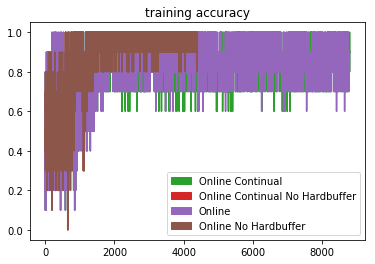

Online Continual: 92.875
Online Continual No Hardbuffer: 94.0
Online: 92.125
Online No Hardbuffer: 94.0
duration: 248.776473045




Start experiment with alpha: 0.8

Online Continual
duration: 1.67901895046minutes, count updates: 20

Online Continual No Hardbuffer
duration: 0.633694303036minutes, count updates: 1

Online
duration: 1.17198539972minutes, count updates: 0

Online No Hardbuffer
duration: 0.662657217185minutes, count updates: 0


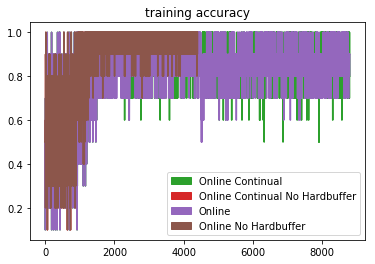

Online Continual: 93.125
Online Continual No Hardbuffer: 96.0
Online: 94.375
Online No Hardbuffer: 95.625
duration: 251.528839111




Start experiment with alpha: 0.7

Online Continual


KeyboardInterrupt: 

In [90]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=1.0
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.9
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.8
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.7
meta_experiment()
print "duration: "+str(time.time()-start_exp)
alpha=0.5
meta_experiment()
print "duration: "+str(time.time()-start_exp)
alpha=0.25
meta_experiment()
print "duration: "+str(time.time()-start_exp)

In [84]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=0.5
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.25
meta_experiment()
print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.5

Online Continual
duration: 1.81288706462minutes

Online Continual No Hardbuffer
duration: 0.483885582288minutes

Online
duration: 1.16166514953minutes

Online No Hardbuffer
duration: 0.536086666584minutes
Online Continual: 96.75
Online Continual No Hardbuffer: 90.75
Online: 95.25
Online No Hardbuffer: 90.75
duration: 242.185775042




Start experiment with alpha: 0.25

Online Continual
duration: 1.89319343567minutes

Online Continual No Hardbuffer
duration: 0.604311382771minutes

Online
duration: 1.42261894941minutes

Online No Hardbuffer
duration: 0.587824332714minutes
Online Continual: 90.25
Online Continual No Hardbuffer: 92.625
Online: 93.75
Online No Hardbuffer: 92.625
duration: 272.621608973


In [83]:
# total set of experiments, estimated time: 20minutes
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=0.5

start_exp=time.time()
alpha=1.0
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.9
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.8
meta_experiment()
print "duration: "+str(time.time()-start_exp)
start_exp=time.time()
alpha=0.7
meta_experiment()
print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0

Online Continual
duration: 1.71087646484minutes

Online Continual No Hardbuffer
duration: 0.648346265157minutes

Online
duration: 1.00775218407minutes

Online No Hardbuffer
duration: 0.520392334461minutes
Online Continual: 90.375
Online Continual No Hardbuffer: 83.75
Online: 85.0
Online No Hardbuffer: 80.875
duration: 234.277907133




Start experiment with alpha: 0.9

Online Continual
duration: 1.63866571585minutes

Online Continual No Hardbuffer
duration: 0.488980066776minutes

Online
duration: 1.02931704919minutes

Online No Hardbuffer
duration: 0.520264581839minutes
Online Continual: 94.5
Online Continual No Hardbuffer: 95.375
Online: 91.75
Online No Hardbuffer: 95.375
duration: 221.873847961




Start experiment with alpha: 0.8

Online Continual
duration: 1.38627827962minutes

Online Continual No Hardbuffer
duration: 0.436142317454minutes

Online
duration: 0.96823195219minutes

Online No Hardbuffer
duration: 0.459879601002minutes
Online Contin





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.745089054108
step 2:  0.521153211594
step 3:  0.0101759433746

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

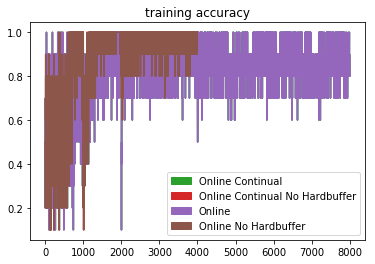

Online Continual: 85.0
Online Continual No Hardbuffer: 80.875
Online: 85.0
Online No Hardbuffer: 80.875
duration: 233.611252069


In [72]:
# lambda 0.5 -> 1. and loss_window_length 10 -> 50
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
loss_window_length=50
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=1

start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.551609992981
step 2:  0.674543142319
step 3:  0.0183930397034

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

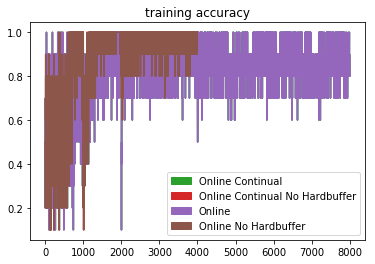

Online Continual: 85.0
Online Continual No Hardbuffer: 80.875
Online: 85.0
Online No Hardbuffer: 80.875
duration: 208.101047039


In [69]:
# lambda 0.5 -> 1.
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
loss_window_length=10
loss_window_mean_threshold=0.15
loss_window_variance_threshold=5*10**-5
continual_learning=True
MAS_weight=1

start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.597409009933
step 2:  0.602843999863
step 3:  0.264185905457

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weigh

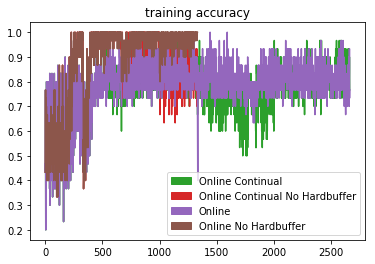

Online Continual: 85.25
Online Continual No Hardbuffer: 79.5
Online: 86.375
Online No Hardbuffer: 79.125
duration: 88.8589458466


In [67]:
# ALPHA 1 BATCHSIZE 30
learning_rate=0.0009
ntrain=10000
batch_size=30
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.595020055771
step 2:  0.451049089432
step 3:  0.00874710083008

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
duration: 1.58722044627minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
duration: 0.586535016696minutes

Online
duration: 1.0988192002minutes

Online No Hardbuffer
duration: 0.526490330696minutes


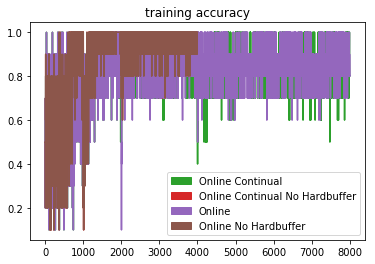

Online Continual: 90.375
Online Continual No Hardbuffer: 83.75
Online: 85.0
Online No Hardbuffer: 80.875
duration: 229.714209795


In [66]:
# ALPHA 1 HIDDEN UNITS 8 --> 10
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 10
gradient_steps = 5
seed=512
alpha=1.0
ntasks=4
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 1.0
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.552947044373
step 2:  0.465765953064
step 3:  0.00892496109009

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

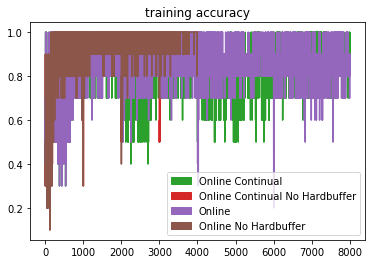

Online Continual: 80.625
Online Continual No Hardbuffer: 77.625
Online: 79.5
Online No Hardbuffer: 79.0
duration: 254.973618031


In [64]:
# ALPHA 1
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=1.0
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.75
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.663951873779
step 2:  0.667860031128
step 3:  0.0139470100403

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

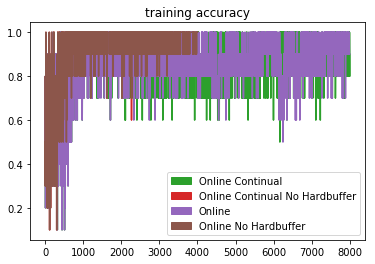

Online Continual: 96.375
Online Continual No Hardbuffer: 93.0
Online: 97.25
Online No Hardbuffer: 93.125
duration: 212.214694977


In [63]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.5
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.556869983673
step 2:  0.808521986008
step 3:  0.0102970600128

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

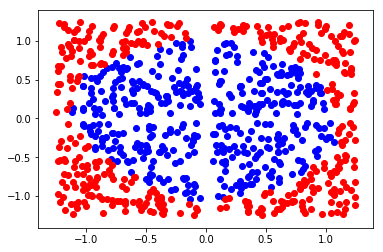

duration: 1.76641845306minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights
Update importance weights


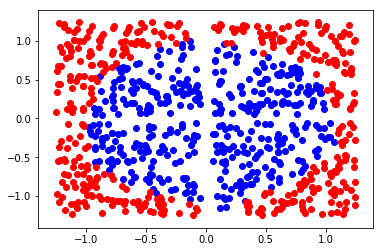

duration: 0.836305467288minutes

Online


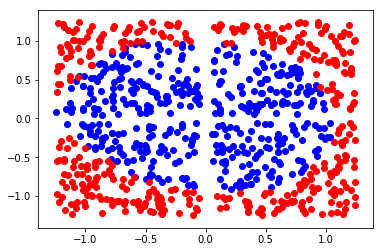

duration: 0.998314547539minutes

Online No Hardbuffer


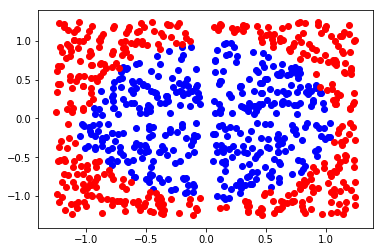

duration: 0.526767083009minutes


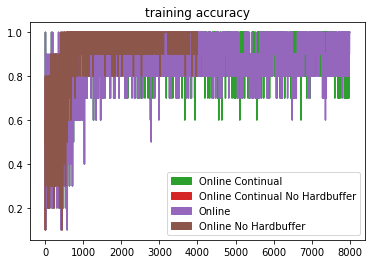

Online Continual: 93.375
Online Continual No Hardbuffer: 94.5
Online: 91.375
Online No Hardbuffer: 95.5
duration: 249.756286144


In [60]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.5 #,0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.540539979935
step 2:  1.00458478928
step 3:  0.00939416885376

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance wei

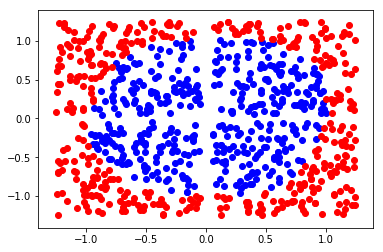

duration: 1.93008826971minutes

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights


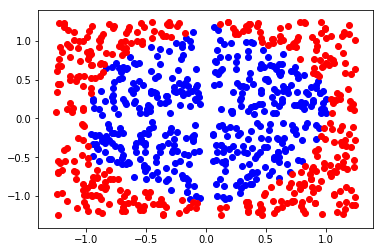

duration: 0.926664551099minutes

Online


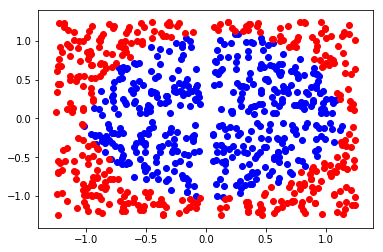

duration: 1.07212363084minutes

Online No Hardbuffer


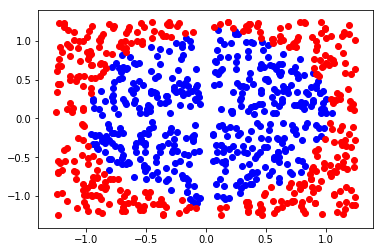

duration: 0.510560115178minutes


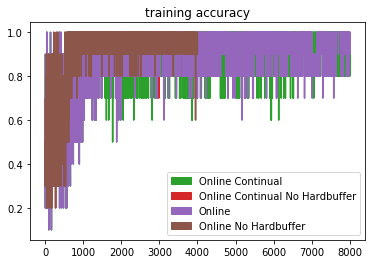

Online Continual: 95.625
Online Continual No Hardbuffer: 95.375
Online: 92.75
Online No Hardbuffer: 94.25
duration: 268.822097063


In [59]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment()

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.544951200485
step 2:  1.08509397507
step 3:  0.0105769634247

Online Continual
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weights
Update importance weig

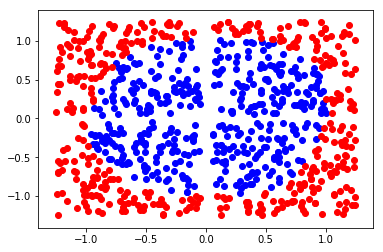

duration: 1.7605008324minutes


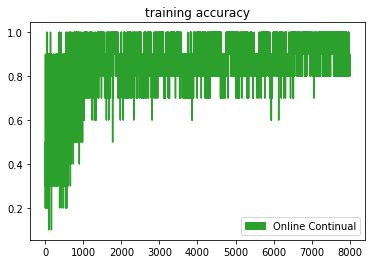

Online Continual: 95.625
duration: 107.675825119


In [58]:
tags=['Online Continual']
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.548987150192
step 2:  0.97009396553
step 3:  0.0090639591217

Online Continual No Hardbuffer
Update importance weights
Update importance weights
Update importance weights


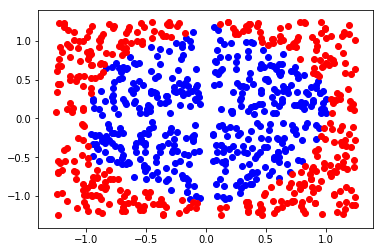

duration: 0.663563152154minutes


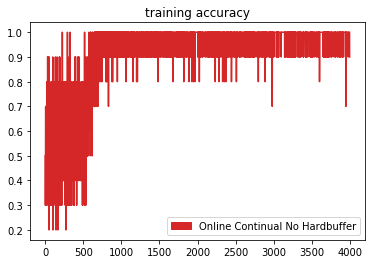

Online Continual No Hardbuffer: 95.375
duration: 41.7339081764


In [54]:
tags=['Online Continual No Hardbuffer']
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.651969909668
step 2:  0.94044303894
step 3:  0.00850796699524

Online


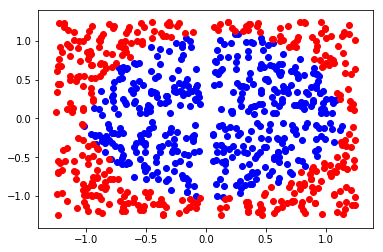

duration: 1.12257143259minutes


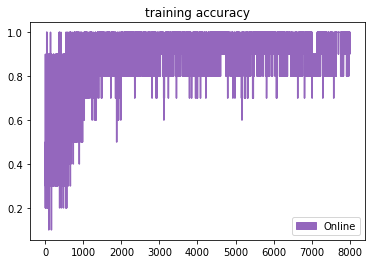

Online: 92.75
duration: 69.423197031


In [56]:
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
tags=['Online']
start_exp=time.time()
meta_experiment(tags)

print "duration: "+str(time.time()-start_exp)





Start experiment with alpha: 0.25
quadrant 0
quadrant 1
quadrant 2
quadrant 3
step 1:  0.556836128235
step 2:  1.09945893288
step 3:  0.0166120529175

Online No Hardbuffer


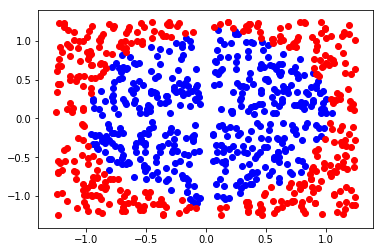

duration: 0.571270616849minutes


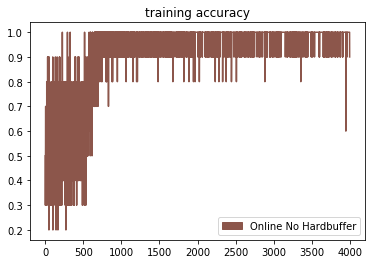

Online No Hardbuffer: 94.25
duration: 36.3032770157


In [57]:
# Optimal setting for Online No Continual and No Hardbuffer
learning_rate=0.0009
ntrain=10000
batch_size=10
hidden_units = 8
gradient_steps = 5
seed=512
alpha=0.25 #0.5,0.75
tags=['Online No Hardbuffer']
start_exp=time.time()
meta_experiment(tags)
print "duration: "+str(time.time()-start_exp)

In [3]:

def sample_data():
    global task, train_data, test_data, inputs, labels, test_inputs
    # seed
    rn.seed(512)
    verbose=False
    # i=0
    for i in range(ntasks):
        mean=np.zeros((dim))
        mean[0]=i
        variance=var*np.identity(dim)
        task[i]=rn.multivariate_normal(mean,variance,nsamples)
        if verbose: plt.plot([j[0] for j in task[i]],[j[1] for j in task[i]],icon[i%ntasks])

    if verbose: plt.show()

    # Step 2: Split test and train data for i task
    for t in task.keys():
        train_data[t]=task[t][0:ntrain]
        test_data[t]=task[t][ntrain:]

    # Step 3: Sample correct distribution given certain alpha
    for i in range(ntasks):
        if verbose: print("Episode: ",i)
        original_task=rn.binomial(np.ones((ntrain),dtype=np.int),alpha) #1 if original task, 0 if data sampled from 1 of the others.
        inputs[i]=[]
        labels[i]=[]
        other_labels=range(ntasks)
        del other_labels[i]
#         print other_labels
        for v in original_task:
            if v:
                label=i
            else:
                label=rn.choice(other_labels)
            sample=task[label][0] # samples are popped from the distribution to avoid them to be reused.
            task[label]=task[label][1:]
            labels[i].append(label)
            inputs[i].append(sample)
            if verbose: plt.plot(sample[0],sample[1],icon[label])
        if verbose: plt.show()

    # draw some extra test data to evaluate
    for i in range(ntasks):
        test_inputs[i]=task[i][:200]
    

done
0:proportion positive/total=0.518017552917
1:proportion positive/total=0.517526625995
2:proportion positive/total=0.523834143315
training data:  0


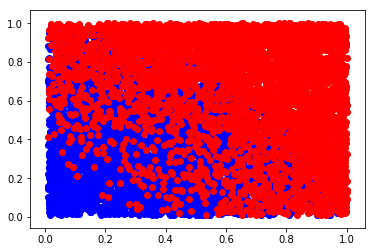

test data:  0


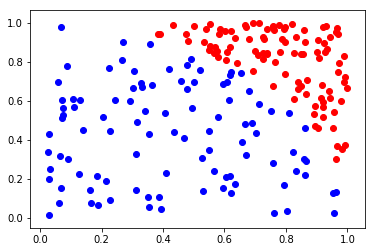

training data:  1


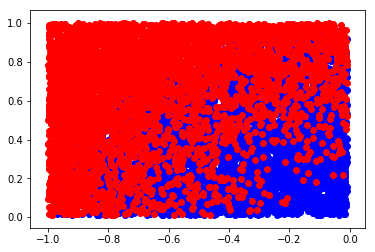

test data:  1


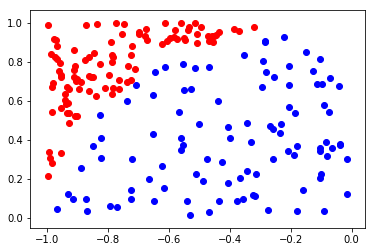

training data:  2


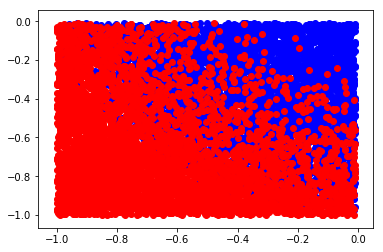

test data:  2


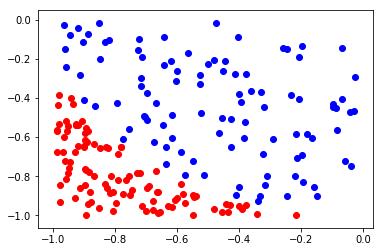

In [24]:
dim=3 # if dimension decrease uniform_width should increase
verbose=False
uniform_width=1.0
nsamples=100000
offset=0.01
alpha=1.0
#offset=0.03
ntest=200
print 'done'
sample_data()
if True:
    for q in range(ntasks):
        print "training data: ",str(q)
        positive_points=[inputs[q][i] for i in range(len(inputs[q])) if labels[q][i]==1]
        negative_points=[inputs[q][i] for i in range(len(inputs[q])) if labels[q][i]==0]
        plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
        plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
        plt.show()

        print "test data: ",str(q)
        positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==1]
        negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if test_labels[q][i]==0]
        plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
        plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
        plt.show()

In [17]:
# Step 4: Define network
def experiment(use_hard_buffer=False,continual_learning=False,recent_buffer_size=30,hard_buffer_size=30):
    count_updates=0
    torch.manual_seed(seed)
    device = torch.device(dev)
    model = torch.nn.Sequential(
              torch.nn.Linear(dim, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, hidden_units, bias=True),
              torch.nn.ReLU(),
              torch.nn.Linear(hidden_units, 2, bias=False),
    ).to(device)

    loss_fn = torch.nn.MSELoss(reduction='none')
    #loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer=torch.optim.Adadelta(model.parameters(), lr=learning_rate)
    # Reinitialize model
    for p in model.parameters():
        torch.nn.init.normal_(p, 0, 0.1)
    # Step 5: Define online loop through data + evaluation + visualization
    # Step 6: Define hard buffer
    # Step 7: Detect loss saturation
    # Step 8: >>Calculate importance weights<<
    # Step 9: Add regularizer
    stime=time.time()
    verbose=False
    losses=[]
    test_loss={i:[] for i in range(ntasks)}
    recent_buffer=[]
    hard_buffer=[]
    # loss dectection
    loss_window=[]
    loss_window_means=[]
    loss_window_variances=[]
    update_tags=[]
    new_peak_detected=True
    # MAS regularization: list of 3 weights vectors as there are 3 layers.
    star_variables=[]
    omegas=[] #initialize with 0 importance weights
    for t in range(ntasks):
        for s in range(len(inputs[t])):
            # plt.scatter(inputs[t][s][0],inputs[t][s][1],color='red' if labels[t][s]==0 else 'blue')
            # save experience in replaybuffer
            recent_buffer.append({'state':inputs[t][s],
                                 'trgt':labels[t][s]})
            if len(recent_buffer) > recent_buffer_size:
                del recent_buffer[0]
            
            # Train model on replaybuffer when it is full:
            if len(recent_buffer) == recent_buffer_size:
                msg='task: {0} step: {1}'.format(t,s)
                x=[_['state'] for _ in recent_buffer]
                y=[_['trgt'] for _ in recent_buffer]
                if use_hard_buffer:
                    x.extend([_['state'] for _ in hard_buffer])
                    y.extend([_['trgt'] for _ in hard_buffer])

                #for gs in range(2*gradient_steps if not use_hard_buffer else gradient_steps):
                for gs in range(gradient_steps):
                    y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(y),2).scatter_(1,torch.from_numpy(np.asarray(y).reshape(-1,1)).type(torch.LongTensor),1.).type(torch.FloatTensor)
                    #y_sup=torch.from_numpy(np.asarray(y)).type(torch.LongTensor)
                    train_loss = loss_fn(y_pred,y_sup)
                    total_loss = loss_fn(y_pred,y_sup)
                    
                    # add MAS regularization to train loss...
                    if continual_learning and len(star_variables)!=0 and len(omegas)!=0:
                        for pindex, p in enumerate(model.parameters()):
                            total_loss+=MAS_weight/2*torch.sum(torch.from_numpy(omegas[pindex]).type(torch.float32)*(p-star_variables[pindex])**2)
                    # train
                    optimizer.zero_grad()
                    #model.zero_grad()
#                    train_loss.backward()
                    torch.sum(total_loss).backward()
                    #with torch.no_grad():
                    #    for param in model.parameters(): param.data -= learning_rate * param.grad
                    optimizer.step()
                
                # save training accuracy
                y_pred = model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                accuracy = np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==y)
                loss=train_loss.detach().numpy()
                msg+=' train: {0:0.3f}'.format(np.mean(loss))
                losses.append(np.mean(accuracy))
                
                # empty recent buffer after training couple of times
                recent_buffer = []
            
                # add loss to loss_window and detect importance weight update
                loss_window.append(np.mean(loss))
                if len(loss_window)>loss_window_length: del loss_window[0]
                loss_window_mean=np.mean(loss_window)
                loss_window_variance=np.var(loss_window)
                if not new_peak_detected and loss_window_mean > last_loss_window_mean+last_loss_window_variance:
                    new_peak_detected=True
                if continual_learning and loss_window_mean < loss_window_mean_threshold and loss_window_variance < loss_window_variance_threshold and new_peak_detected:
                    #print("Update importance weights")
                    count_updates+=1
                    update_tags.append(0.01)
                    last_loss_window_mean=loss_window_mean
                    last_loss_window_variance=loss_window_variance
                    new_peak_detected=False
                    
                    # calculate importance weights and update star_variables
                    model.zero_grad()
                    y_pred=model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    torch.sum(torch.norm(y_pred, 2, dim=1)).backward()
                    omegas_old = omegas[:]
                    omegas=[]
                    star_variables=[]
                    for pindex, p in enumerate(model.parameters()):
                        if len(omegas_old) != 0:
                            omegas.append(1/count_updates*np.abs(p.grad.data.clone().detach().numpy())+(1-1/count_updates)*omegas_old[pindex])
                        else:
                            omegas.append(np.abs(p.grad.data.clone().detach().numpy()))
                        star_variables.append(p.data.clone().detach())
                    #print omegas_old
                    #print omegas
                    #import pdb; pdb.set_trace()
                    gradients=[0 for p in model.parameters()]
                    for sx in x:
                        model.zero_grad()
                        y_pred=model(torch.from_numpy(np.asarray(sx).reshape(-1,dim)).type(torch.float32))
                        torch.sum(torch.norm(y_pred, 2, dim=1)).backward()
                        for pindex, p in enumerate(model.parameters()):
                            g=p.grad.data.clone().detach().numpy()
                            gradients[pindex]+=np.abs(g)
                    print gradients[0]
                    model.zero_grad()
                    y_pred=model(torch.from_numpy(np.asarray(x).reshape(-1,dim)).type(torch.float32))
                    torch.sum(torch.norm(y_pred, 2, dim=1)).backward()
                    for p in model.parameters():
                        print np.abs(p.grad.data.clone().detach().numpy())
                        break
                    import pdb; pdb.set_trace()
                else:
                    update_tags.append(0)
                loss_window_means.append(loss_window_mean)
                loss_window_variances.append(loss_window_variance)

                #update hard_buffer
                if use_hard_buffer:
                    hard_buffer=[]
                    loss=np.mean(loss,axis=1)
                    try:
                        sorted_inputs=[np.asarray(lx) for _,lx in reversed(sorted(zip(loss.tolist(),x),key= lambda f:f[0]))]
                        sorted_targets=[ly for _,ly in reversed(sorted(zip(loss.tolist(),y),key= lambda f:f[0]))]
                    except:
                        import pdb; pdb.set_trace()
                    for i in range(min(hard_buffer_size,len(sorted_inputs))):
                        hard_buffer.append({'state':sorted_inputs[i],
                                           'trgt':sorted_targets[i]})
                #evaluate on test set
                for i in range(ntasks):
                    y_pred=model(torch.from_numpy(test_inputs[i].reshape(-1,dim)).type(torch.float32))
                    y_sup=torch.zeros(len(test_inputs[i]),2).scatter_(1,torch.from_numpy(np.asarray(test_labels[i]).reshape(-1,1)),1.).type(torch.FloatTensor)
                    #loss=loss_fn(y_pred,y_sup).detach().numpy()
                    test_loss[i].append(np.mean(np.argmax(y_pred.detach().numpy(),axis=1)==test_labels[i]))
                    msg+=' test[{0}]: {1:0.3f}'.format(i,np.mean(loss))
                if verbose:
                    print(msg)
    if False and use_hard_buffer:
        xs_pos=[_['state'][0] for _ in hard_buffer if _['trgt']==1]
        ys_pos=[_['state'][1] for _ in hard_buffer if _['trgt']==1]
        xs_neg=[_['state'][0] for _ in hard_buffer if _['trgt']==0]
        ys_neg=[_['state'][1] for _ in hard_buffer if _['trgt']==0]
        plt.scatter(xs_pos,ys_pos,color='blue')
        plt.scatter(xs_neg,ys_neg,color='red')
        plt.title('replay buffer')
        plt.show()
        
    if False:
        for q in range(ntasks):
            y_pred=model(torch.from_numpy(test_inputs[q].reshape(-1,dim)).type(torch.float32)).detach().numpy()
            positive_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==1]
            negative_points=[test_inputs[q][i] for i in range(len(test_inputs[q])) if np.argmax(y_pred[i])==0]
            plt.scatter([p[0] for p in positive_points],[p[1] for p in positive_points],color='blue')
            plt.scatter([p[0] for p in negative_points],[p[1] for p in negative_points],color='red')
        plt.show()
    
    print("duration: {0}minutes, count updates: {1}".format((time.time()-stime)/60., count_updates))
    return losses, loss_window_means, update_tags, loss_window_variances, test_loss
#     return losses, test_loss

